# NFL Injury Prediction

By Kushal Gourikrishna

## Problem Statement

The NFL has always been a very violent sport and injuries are an unfortunate byproduct of this. However, aside from injuries suffered due to the physicality of the game there are also a large number of non-contact injuries that are suffered every year. There has been a suspicion that turf type can have an impact on player injuries but there are a variety of factors on every play that could play a role such as the speed and direction of the player, weather conditions, stadium, etc. 

## Objective

Build and test different classification models and choose a model that can help predict injuries to NFL players based on a suite of factors present during a typical NFL game.

## Setup

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras as kr
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, classification_report,recall_score,precision_score,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
# load the data
injury_record = pd.read_csv('InjuryRecord.csv')
player_track_data = pd.read_csv('PlayerTrackData.csv')
play_list = pd.read_csv('PlayList.csv')

In [3]:
# set the max columns to 50
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows',50)

## Data Exploration and Cleaning

### Injury Data

In [4]:
#See head of injury record data
injury_record.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [5]:
#See baseline stats of injury record
injury_record.describe(include='all')

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
count,105.000000,105,77,105,105,105.0,105.000000,105.000000,105.000000
unique,NaN,104,76,5,2,NaN,NaN,NaN,NaN
top,NaN,47307-10,47307-10-18,Knee,Synthetic,NaN,NaN,NaN,NaN
freq,NaN,2,2,48,57,NaN,NaN,NaN,NaN
mean,42283.609524,NaN,NaN,NaN,NaN,1.0,0.723810,0.352381,0.276190
std,4163.510366,NaN,NaN,NaN,NaN,0.0,0.449257,0.480003,0.449257
min,31070.000000,NaN,NaN,NaN,NaN,1.0,0.000000,0.000000,0.000000
25%,39656.000000,NaN,NaN,NaN,NaN,1.0,0.000000,0.000000,0.000000
50%,43518.000000,NaN,NaN,NaN,NaN,1.0,1.000000,0.000000,0.000000
75%,45966.000000,NaN,NaN,NaN,NaN,1.0,1.000000,1.000000,1.000000


#### Fill Nulls for Injury Data

In [6]:
#Check injury data for nulls
injury_record.isnull().sum()

PlayerKey     0
GameID        0
PlayKey      28
BodyPart      0
Surface       0
DM_M1         0
DM_M7         0
DM_M28        0
DM_M42        0
dtype: int64

In [7]:
#Fill missing PlayKey values in injury dataframe with last play recorded for that Game
injury_record['PlayKey'] = injury_record.apply(
    lambda row: play_list.loc[play_list['GameID'] == row['GameID']].iloc[-1]['PlayKey'] if pd.isnull(row['PlayKey']) else row['PlayKey'],
    axis=1
)

In [8]:
#Check injury data for nulls after filling missing values
injury_record.isnull().sum()

PlayerKey    0
GameID       0
PlayKey      0
BodyPart     0
Surface      0
DM_M1        0
DM_M7        0
DM_M28       0
DM_M42       0
dtype: int64

### Play List Data

In [9]:
play_list.head(15)

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB
5,26624,26624-1,26624-1-6,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,6,QB,QB
6,26624,26624-1,26624-1-7,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,7,QB,QB
7,26624,26624-1,26624-1-8,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,8,QB,QB
8,26624,26624-1,26624-1-9,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,9,QB,QB
9,26624,26624-1,26624-1-10,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,10,QB,QB


In [10]:
play_list.describe(include='all')

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
count,267005.000000,267005,267005,267005,267005.000000,267005.000000,250095,267005,267005.000000,248314,266638,267005.000000,267005,267005
unique,NaN,5712,267005,10,NaN,NaN,29,2,NaN,63,11,NaN,23,10
top,NaN,41113-13,26624-1-1,Linebacker,NaN,NaN,Outdoor,Natural,NaN,Cloudy,Pass,NaN,WR,DB
freq,NaN,102,1,50129,NaN,NaN,145032,156902,NaN,60705,138079,NaN,43457,68295
mean,41515.381465,NaN,NaN,NaN,210.451351,13.799131,NaN,NaN,-35.029535,NaN,NaN,29.058647,NaN,NaN
std,4125.858924,NaN,NaN,NaN,183.643654,8.342894,NaN,NaN,304.583110,NaN,NaN,19.626551,NaN,NaN
min,26624.000000,NaN,NaN,NaN,-62.000000,1.000000,NaN,NaN,-999.000000,NaN,NaN,1.000000,NaN,NaN
25%,39653.000000,NaN,NaN,NaN,43.000000,7.000000,NaN,NaN,44.000000,NaN,NaN,13.000000,NaN,NaN
50%,42432.000000,NaN,NaN,NaN,102.000000,13.000000,NaN,NaN,61.000000,NaN,NaN,26.000000,NaN,NaN
75%,44480.000000,NaN,NaN,NaN,400.000000,20.000000,NaN,NaN,72.000000,NaN,NaN,43.000000,NaN,NaN


#### Check Nulls for Play List Data

In [11]:
play_list.isnull().sum()

PlayerKey             0
GameID                0
PlayKey               0
RosterPosition        0
PlayerDay             0
PlayerGame            0
StadiumType       16910
FieldType             0
Temperature           0
Weather           18691
PlayType            367
PlayerGamePlay        0
Position              0
PositionGroup         0
dtype: int64

#### Clean Play List and normalize categorical variables

In [12]:
play_list['StadiumType'].unique()

array(['Outdoor', 'Indoors', 'Oudoor', 'Outdoors', 'Open', 'Closed Dome',
       'Domed, closed', nan, 'Dome', 'Indoor', 'Domed',
       'Retr. Roof-Closed', 'Outdoor Retr Roof-Open', 'Retractable Roof',
       'Ourdoor', 'Indoor, Roof Closed', 'Retr. Roof - Closed', 'Bowl',
       'Outddors', 'Retr. Roof-Open', 'Dome, closed', 'Indoor, Open Roof',
       'Domed, Open', 'Domed, open', 'Heinz Field', 'Cloudy',
       'Retr. Roof - Open', 'Retr. Roof Closed', 'Outdor', 'Outside'],
      dtype=object)

In [13]:
play_list['Weather'].unique()

array(['Clear and warm', 'Mostly Cloudy', 'Sunny', 'Clear', 'Cloudy',
       'Cloudy, fog started developing in 2nd quarter', 'Rain',
       'Partly Cloudy', 'Mostly cloudy', 'Cloudy and cold',
       'Cloudy and Cool', 'Rain Chance 40%', 'Controlled Climate',
       'Sunny and warm', 'Partly cloudy', 'Clear and Cool',
       'Clear and cold', 'Sunny and cold', 'Indoor', nan, 'Partly Sunny',
       'N/A (Indoors)', 'Mostly Sunny', 'Indoors', 'Clear Skies',
       'Partly sunny', 'Showers', 'N/A Indoor', 'Sunny and clear', 'Snow',
       'Scattered Showers', 'Party Cloudy', 'Clear skies',
       'Rain likely, temps in low 40s.', 'Hazy', 'Partly Clouidy',
       'Sunny Skies', 'Overcast', 'Cloudy, 50% change of rain', 'Fair',
       'Light Rain', 'Partly clear', 'Mostly Coudy', '10% Chance of Rain',
       'Cloudy, chance of rain', 'Heat Index 95',
       'Sunny, highs to upper 80s', 'Sun & clouds',
       'Heavy lake effect snow', 'Mostly sunny', 'Cloudy, Rain',
       'Sunny, Windy', '

In [14]:
array_outdoors = ['Outdoor', 'Oudoor', 'Outdoors',
       'Ourdoor', 'Outddors', 'Heinz Field', 'Outdor', 'Outside', 'Cloudy']
array_indoors = ['Indoors', 'Indoor', 'Indoor', 'Retractable Roof']
array_open = ['Open','Outdoor Retr Roof-Open', 'Retr. Roof-Open', 'Indoor, Open Roof',
       'Domed, Open', 'Domed, open', 'Retr. Roof - Open']
array_closed = ['Closed Dome', 'Domed, closed', 'Dome', 'Domed',
       'Retr. Roof-Closed', 'Outdoor Retr Roof-Open', 'Retractable Roof', 'Indoor, Roof Closed', 'Retr. Roof - Closed', 'Bowl', 'Dome, closed',
       'Retr. Roof Closed']

play_list['StadiumType'] = play_list['StadiumType'].replace(array_outdoors, 'Outdoors')
play_list['StadiumType'] = play_list['StadiumType'].replace(array_indoors, 'Indoors')
play_list['StadiumType'] = play_list['StadiumType'].replace(array_open, 'Roof Open')
play_list['StadiumType'] = play_list['StadiumType'].replace(array_closed, 'Roof Closed')

In [15]:
array_clear = ['Clear and warm', 'Sunny', 'Clear',
       'Sunny and warm', 'Clear and Cool',
       'Clear and cold', 'Sunny and cold', 'Partly Sunny',
       'Mostly Sunny', 'Clear Skies', 'Partly sunny', 
       'Sunny and clear', 'Clear skies',
       'Sunny Skies', 'Fair', 'Partly clear', 
       'Heat Index 95', 'Sunny, highs to upper 80s', 
       'Mostly sunny', 'Sunny, Windy', 'Mostly Sunny Skies', 
       'Clear and Sunny', 'Clear and sunny',
       'Clear to Partly Cloudy', 'Cold']

array_cloudy = ['Mostly Cloudy', 'Cloudy',
       'Cloudy, fog started developing in 2nd quarter',
       'Partly Cloudy', 'Mostly cloudy', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy', 
       'Party Cloudy', 'Hazy', 'Partly Clouidy',
       'Overcast', 'Cloudy, 50% change of rain',
       'Mostly Coudy', 'Cloudy, chance of rain',
       'Sun & clouds', 'Cloudy, Rain',
       'cloudy', 'Coudy']

array_indoors = ['Controlled Climate','Indoor',
       'N/A (Indoors)', 'Indoors', 'N/A Indoor']

array_precip = ['Rain',
       'Snow',
       'Scattered Showers',
       'Light Rain',
       'Heavy lake effect snow', 'Cloudy, Rain',
       'Rainy',
       'Cloudy, light snow accumulating 1-3"',
       'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
       'Rain shower', 'Rain likely, temps in low 40s.', 'Rain Chance 40%', 'Rain likely, temps in low 40s.',
       'Cloudy, 50% change of rain', '10% Chance of Rain', 'Showers', '30% Chance of Rain']

play_list['Weather'] = play_list['Weather'].replace(array_clear, 'Clear')
play_list['Weather'] = play_list['Weather'].replace(array_cloudy, 'Cloudy')
play_list['Weather'] = play_list['Weather'].replace(array_indoors, 'Indoors')
play_list['Weather'] = play_list['Weather'].replace(array_precip, 'Precipitation')

##### After cleaning, fill nulls and invalid data for Play List data

In [16]:
#Fill stadium type nulls for outdoor "weather" with "Outdoors"
play_list.loc[(play_list['StadiumType'].isnull()) & (play_list['Weather'] != 'Indoors'),'StadiumType'] = 'Outdoors'

In [17]:
#Fill weather nulls for indoor stadiums with indoors
play_list.loc[(play_list['Weather'].isnull()) & ((play_list['StadiumType']!='Roof Open') & (play_list['StadiumType']!='Outdoors')),'Weather'] = 'Indoors'

In [18]:
#Fill weather nulls for outdoor stadiums with mode of cloudy
play_list.loc[play_list['Weather'].isnull(),'Weather'] = 'Cloudy'

In [19]:
#Fill play type nulls with mode which is pass plays
play_list.loc[play_list['PlayType'].isnull(),'PlayType'] = 'Pass'

In [20]:
#Check that null values of play list are gone
play_list.isnull().sum()

PlayerKey         0
GameID            0
PlayKey           0
RosterPosition    0
PlayerDay         0
PlayerGame        0
StadiumType       0
FieldType         0
Temperature       0
Weather           0
PlayType          0
PlayerGamePlay    0
Position          0
PositionGroup     0
dtype: int64

In [21]:
play_list['PlayType'].value_counts()

Pass                    138446
Rush                     92606
Extra Point               5906
Kickoff                   5754
Punt                      5746
Field Goal                4915
Kickoff Not Returned      4625
Punt Not Returned         3486
Kickoff Returned          2773
Punt Returned             2469
0                          279
Name: PlayType, dtype: int64

In [22]:
play_list = play_list[play_list.PlayType != '0']

In [23]:
play_list['PlayType'].value_counts()

Pass                    138446
Rush                     92606
Extra Point               5906
Kickoff                   5754
Punt                      5746
Field Goal                4915
Kickoff Not Returned      4625
Punt Not Returned         3486
Kickoff Returned          2773
Punt Returned             2469
Name: PlayType, dtype: int64

In [24]:
#Check rows with temp = -999
play_list.loc[play_list['Temperature'] == -999]

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
2998,27363,27363-13,27363-13-1,Quarterback,88,13,Roof Closed,Synthetic,-999,Cloudy,Rush,1,QB,QB
2999,27363,27363-13,27363-13-2,Quarterback,88,13,Roof Closed,Synthetic,-999,Cloudy,Pass,2,QB,QB
3000,27363,27363-13,27363-13-3,Quarterback,88,13,Roof Closed,Synthetic,-999,Cloudy,Rush,3,QB,QB
3001,27363,27363-13,27363-13-4,Quarterback,88,13,Roof Closed,Synthetic,-999,Cloudy,Pass,4,QB,QB
3002,27363,27363-13,27363-13-5,Quarterback,88,13,Roof Closed,Synthetic,-999,Cloudy,Pass,5,QB,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266403,47820,47820-2,47820-2-13,Cornerback,8,2,Indoors,Synthetic,-999,Indoors,Kickoff Not Returned,13,CB,DB
266404,47820,47820-2,47820-2-14,Cornerback,8,2,Indoors,Synthetic,-999,Indoors,Kickoff Not Returned,14,CB,DB
266405,47820,47820-2,47820-2-15,Cornerback,8,2,Indoors,Synthetic,-999,Indoors,Kickoff Not Returned,15,CB,DB
266406,47820,47820-2,47820-2-16,Cornerback,8,2,Indoors,Synthetic,-999,Indoors,Punt Not Returned,16,CB,DB


In [25]:
#Replace temp = -999 with 67 for when game is in stadium with roof closed
play_list.loc[(play_list['StadiumType'] == 'Roof Closed') & (play_list['Temperature'] == -999),'Temperature'] = 67


In [26]:
#Replace temp = -999 with 67 for when game is in indoor stadium
play_list.loc[(play_list['StadiumType'] == 'Indoors') & (play_list['Temperature'] == -999),'Temperature'] = 67


In [27]:
#Compute mean temp for all outdoor games
outdoor_temp_mean = play_list.loc[(play_list['StadiumType'] == 'Roof Open') | (play_list['StadiumType'] == 'Outdoors')]['Temperature'].mean()

In [28]:
#Fill temp = -999 with mean of outdoor game temps
play_list.loc[play_list['Temperature'] == -999,'Temperature'] = outdoor_temp_mean

### Player Tracking Data

In [29]:
#Create column in player track data for 'angle' based on orientation and direction
player_track_data['angle'] = player_track_data['o'] - player_track_data['dir']

#Find max and avg values in player tracking data per play for player
grouped_max = player_track_data[['PlayKey','time', 'dir', 'dis', 'o', 's', 'angle']].groupby(by=['PlayKey']).max()
grouped_average = player_track_data[['PlayKey','time', 'dir', 'dis', 'o', 's', 'angle','x','y']].groupby(by=['PlayKey']).mean()
    

### Clean and Merge All Datasets

In [30]:
play_list = play_list.drop(['PositionGroup','Position'],axis=1)

In [31]:
play_inj = pd.merge(play_list,injury_record, on='PlayKey',how='left')

In [32]:
play_inj['DM_M1'] = play_inj['DM_M1'].fillna(0).astype(int)
play_inj['DM_M7'] = play_inj['DM_M7'].fillna(0).astype(int)
play_inj['DM_M28'] = play_inj['DM_M28'].fillna(0).astype(int)
play_inj['DM_M42'] = play_inj['DM_M42'].fillna(0).astype(int)
play_inj['BodyPart'] = play_inj['BodyPart'].fillna('None')

In [33]:
play_inj = play_inj.drop(['PlayerKey_y','GameID_y','Surface'],axis=1)

In [34]:
play_inj.DM_M1 = play_inj.DM_M1 - play_inj.DM_M7
play_inj.DM_M7 = play_inj.DM_M7 - play_inj.DM_M28
play_inj.DM_M28 = play_inj.DM_M28 - play_inj.DM_M42
play_inj['Injury'] = play_inj['DM_M1'] + play_inj['DM_M7'] + play_inj['DM_M28'] + play_inj['DM_M42']

In [35]:
play_inj = play_inj.drop(['DM_M1','DM_M7','DM_M28','DM_M42'],axis=1)

In [36]:
play_inj_track = play_inj.merge(grouped_max.reset_index(), on=['PlayKey'])
play_inj_track = play_inj_track.merge(grouped_average.reset_index(), on=['PlayKey'], suffixes=('_max', '_avg'))

In [37]:
play_inj_track.head()

,PlayerKey_x,GameID_x,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,BodyPart,Injury,time_max,dir_max,dis_max,o_max,s_max,angle_max,time_avg,dir_avg,dis_avg,o_avg,s_avg,angle_avg,x,y
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoors,Synthetic,63.0,Clear,Pass,1,None,0,29.8,337.87,0.48,267.03,2.94,265.19,14.90,186.148361,0.056288,182.479766,0.535753,-3.668595,87.665753,28.221104
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoors,Synthetic,63.0,Clear,Pass,2,None,0,25.9,335.34,0.51,348.42,2.32,259.56,12.95,211.949423,0.090077,209.874077,0.849692,-2.075346,86.616462,29.144077
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoors,Synthetic,63.0,Clear,Rush,3,None,0,29.5,358.43,0.42,272.36,1.46,261.64,14.75,194.134122,0.036081,197.151926,0.331014,3.017804,79.677264,28.900203
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoors,Synthetic,63.0,Clear,Rush,4,None,0,12.6,268.08,0.35,197.21,1.74,137.76,6.30,163.762205,0.054016,170.724016,0.523701,6.961811,72.469449,26.680157
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoors,Synthetic,63.0,Clear,Pass,5,None,0,25.9,355.59,0.45,240.34,2.67,139.25,12.95,222.120577,0.099769,185.502615,0.970385,-36.617962,65.407846,24.865577


In [38]:
play_inj_track = play_inj_track.drop(['dir_max','o_max','dir_avg','o_avg','PlayerKey_x','GameID_x'],axis = 1)

### Merged Data with Feature Columns

In [39]:
#Merged and cleaned dataset with features
play_inj_track['PlayType'].value_counts()

Pass                    138422
Rush                     92600
Extra Point               5906
Kickoff                   5750
Punt                      5743
Field Goal                4912
Kickoff Not Returned      4621
Punt Not Returned         3486
Kickoff Returned          2773
Punt Returned             2469
Name: PlayType, dtype: int64

### Transform Categorical Data 

In [40]:
injury_model_data = pd.get_dummies(play_inj_track, prefix=['RosterPosition'], columns=['RosterPosition'])
injury_model_data = pd.get_dummies(injury_model_data, prefix=['StadiumType'], columns=['StadiumType'])
injury_model_data = pd.get_dummies(injury_model_data, prefix=['FieldType'], columns=['FieldType'])
injury_model_data = pd.get_dummies(injury_model_data, prefix=['Weather'], columns=['Weather'])
injury_model_data = pd.get_dummies(injury_model_data, prefix=['PlayType'], columns=['PlayType'])

injury_model_data = injury_model_data.drop(['PlayKey','BodyPart'],axis=1)


## Exploratory Data Analysis

In [41]:
# Creating numerical columns
num_cols = ['PlayerDay','PlayerGame','Temperature','PlayerGamePlay','time_max','dis_max','s_max','angle_max'
           ,'time_avg','dis_avg','s_avg','angle_avg','x','y']

# Creating categorical variables 
cat_cols = ['Injury','RosterPosition','StadiumType','FieldType','Weather','PlayType']

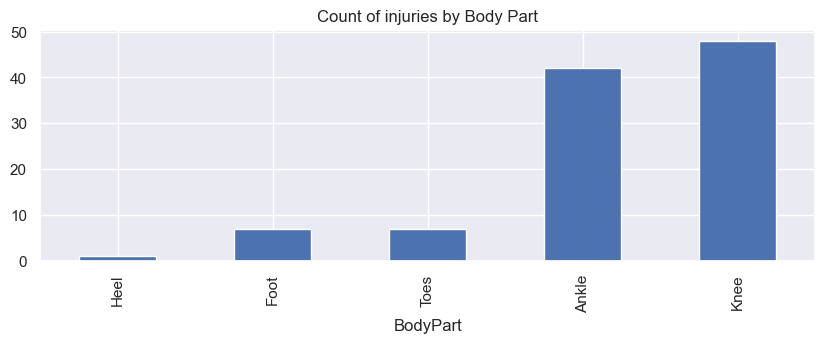

In [42]:
injury_record.groupby('BodyPart').count()['PlayerKey'] \
    .sort_values() \
    .plot(kind='bar', figsize=(10, 3), title='Count of injuries by Body Part')
plt.show()

<AxesSubplot:>

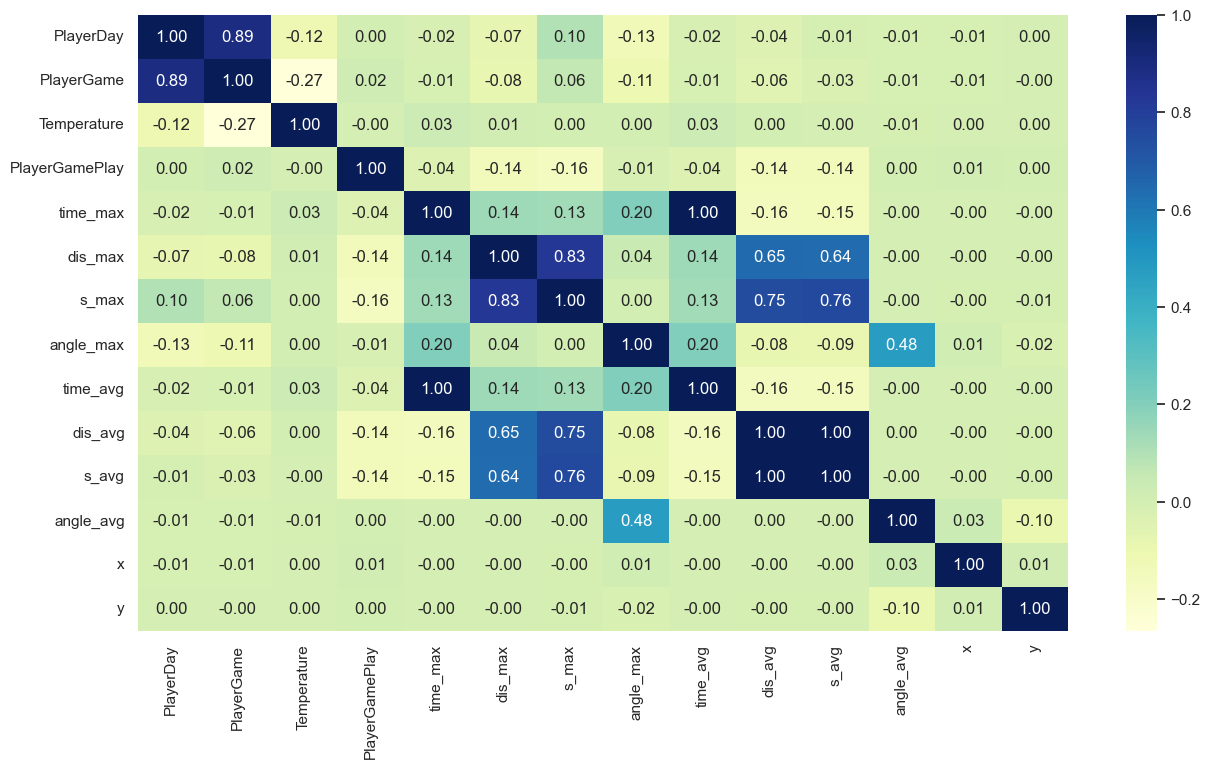

In [43]:
# Plotting the correlation between numerical variables
plt.figure(figsize = (15, 8))

sns.heatmap(injury_model_data[num_cols].corr(), annot = True, fmt = '0.2f', cmap = 'YlGnBu')

In [44]:
#Drop highly correlated features

injury_model_data = injury_model_data.drop(['PlayerGame','time_max','dis_avg'],axis = 1)

In [45]:
num_cols = ['PlayerDay','Temperature','PlayerGamePlay','dis_max','s_max','angle_max'
           ,'time_avg','s_avg','angle_avg','x','y']

<AxesSubplot:>

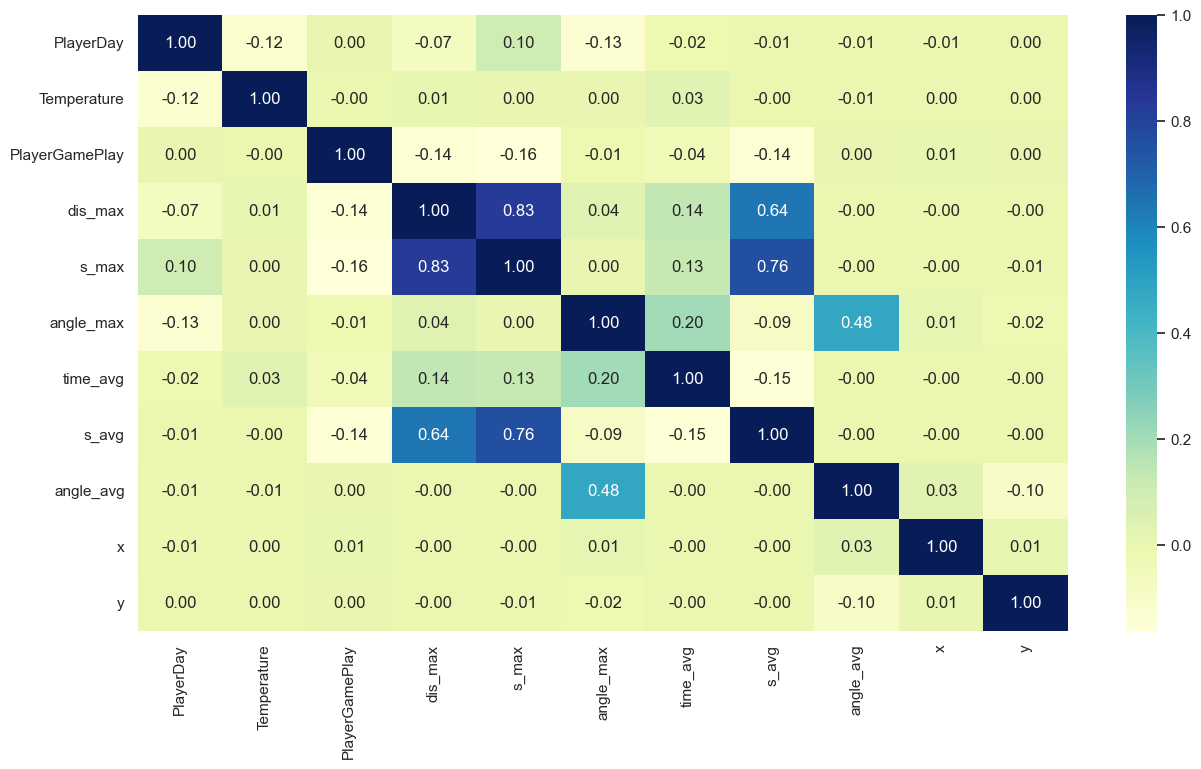

In [46]:
# Plotting the correlation between numerical variables again
plt.figure(figsize = (15, 8))

sns.heatmap(injury_model_data[num_cols].corr(), annot = True, fmt = '0.2f', cmap = 'YlGnBu')

In [47]:
injury_model_data.head()

,PlayerDay,Temperature,PlayerGamePlay,Injury,dis_max,s_max,angle_max,time_avg,s_avg,angle_avg,x,y,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Quarterback,RosterPosition_Running Back,RosterPosition_Safety,RosterPosition_Tight End,RosterPosition_Wide Receiver,StadiumType_Indoors,StadiumType_Outdoors,StadiumType_Roof Closed,StadiumType_Roof Open,FieldType_Natural,FieldType_Synthetic,Weather_Clear,Weather_Cloudy,Weather_Indoors,Weather_Precipitation,PlayType_Extra Point,PlayType_Field Goal,PlayType_Kickoff,PlayType_Kickoff Not Returned,PlayType_Kickoff Returned,PlayType_Pass,PlayType_Punt,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush
0,1,63.0,1,0,0.48,2.94,265.19,14.90,0.535753,-3.668595,87.665753,28.221104,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,63.0,2,0,0.51,2.32,259.56,12.95,0.849692,-2.075346,86.616462,29.144077,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,63.0,3,0,0.42,1.46,261.64,14.75,0.331014,3.017804,79.677264,28.900203,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,63.0,4,0,0.35,1.74,137.76,6.30,0.523701,6.961811,72.469449,26.680157,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,63.0,5,0,0.45,2.67,139.25,12.95,0.970385,-36.617962,65.407846,24.865577,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0


# Model Building

### Create Metrics Function

In [48]:
def metrics_score(actual, predicted, model):
    
    acc = accuracy_score(actual, predicted)
    prec = precision_score(actual, predicted)
    rec = recall_score(actual, predicted)
    f1 = f1_score(actual, predicted)
    roc_auc = roc_auc_score(actual,predicted)

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['No Injury', 'Injury'], yticklabels = ['No Injury', 'Injury'])

    plt.ylabel('Actual')

    plt.xlabel('Predicted')
    
    plt.show()
    
    model_table = pd.DataFrame([[model, acc, 1-rec, rec, prec, f1, roc_auc]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score','ROC_AUC'])
    
    return model_table

### Balancing Dataset

In [49]:
# Split the data into features (X) and target (y)
X = injury_model_data.drop('Injury', axis=1)
y = injury_model_data['Injury']

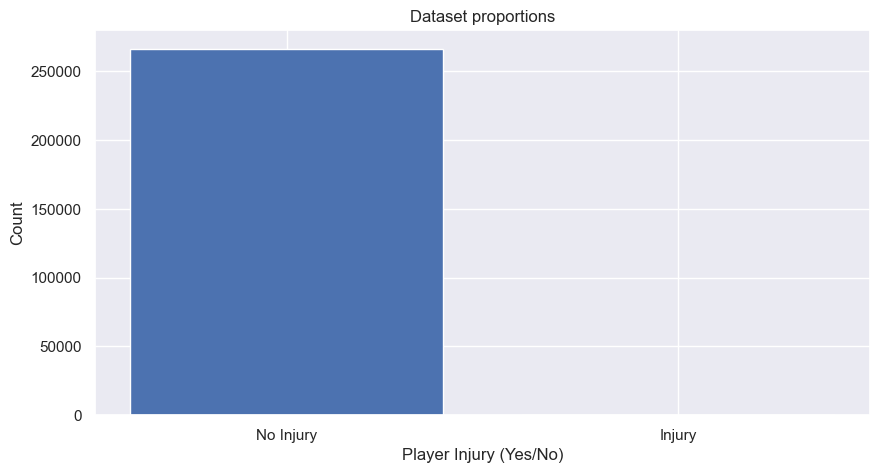

In [50]:
labels, counts = np.unique(y, return_counts=True)
labels = ['No Injury','Injury']

plt.figure(figsize=(10, 5))
plt.bar(labels,counts)
plt.title('Dataset proportions')
plt.xlabel("Player Injury (Yes/No)")
plt.ylabel("Count")
plt.show()

In [51]:
print(counts)

[266577    105]


In [52]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

X_nm, y_nm = nm.fit_resample(X, y)

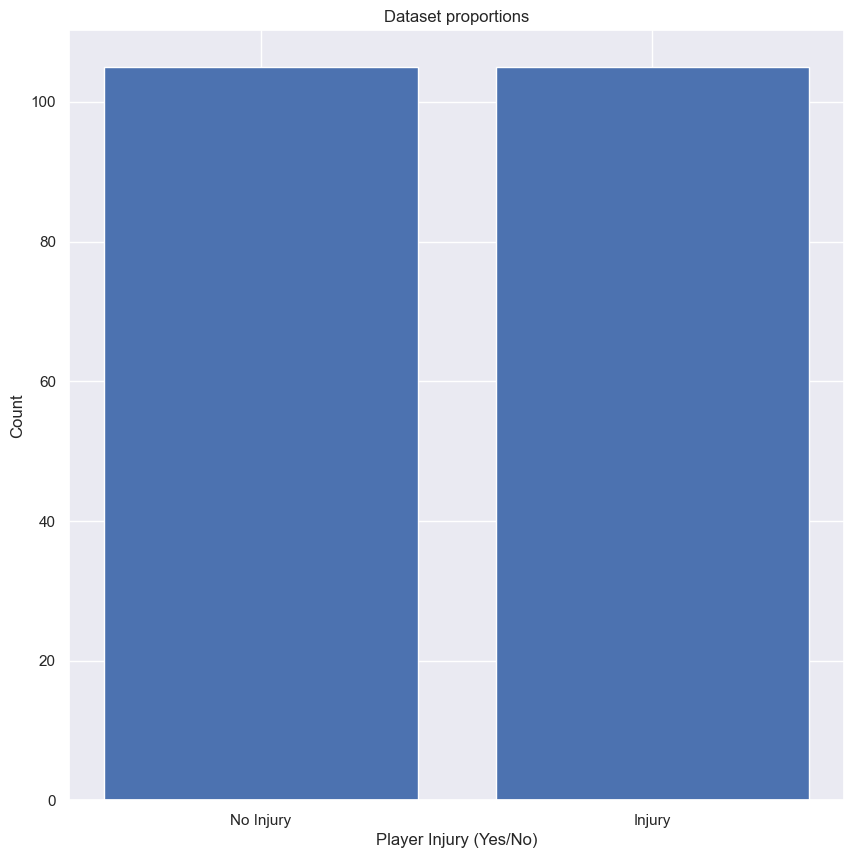

In [53]:
labels, counts = np.unique(y_nm, return_counts=True)
labels = ['No Injury','Injury']

plt.figure(figsize=(10, 10))
plt.bar(labels,counts)
plt.title('Dataset proportions')
plt.xlabel("Player Injury (Yes/No)")
plt.ylabel("Count")
plt.show()

In [54]:
from imblearn.over_sampling import ADASYN 

sm = ADASYN(random_state=42)
X_a, y_a = sm.fit_resample(X, y)

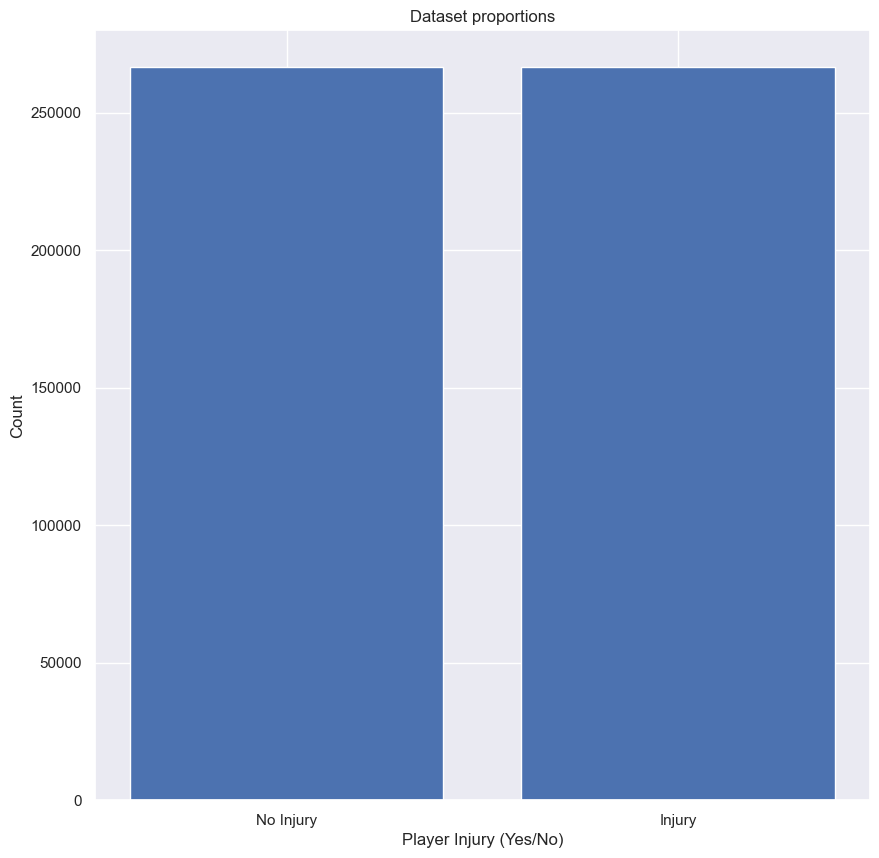

In [55]:
labels, counts = np.unique(y_a, return_counts=True)
labels = ['No Injury','Injury']

plt.figure(figsize=(10, 10))
plt.bar(labels,counts)
plt.title('Dataset proportions')
plt.xlabel("Player Injury (Yes/No)")
plt.ylabel("Count")
plt.show()

### Train/Test Split the Data

#### Split Data Without Augmentation

In [56]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

#Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Split Data with Undersampling

In [57]:
# Split the data into training and test sets
#X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X_nm, y_nm, test_size=0.2,random_state=42, stratify=y_nm)

X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

#Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled_nm = scaler.fit_transform(X_train_nm)
#X_test_scaled_nm = scaler.transform(X_test_nm)

#### Split Data with Oversampling

In [58]:
# Split the data into training and test sets
#X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2,random_state=42, stratify=y_a)

X_train_a, y_train_a = sm.fit_resample(X_train, y_train)

#Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled_a = scaler.fit_transform(X_train_a)
#X_test_scaled_a = scaler.transform(X_test_a)

In [59]:
X_train.shape

(213345, 41)

In [60]:
X_train_nm.shape

(168, 41)

In [61]:
X_train_a.shape

(426516, 41)

## Build Models with Undersampled Data

### KNN 

In [62]:
# Define K-NN model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4)

In [63]:
# Fitting data to the K-NN model

knn.fit(X_train_scaled_nm,y_train_nm)

KNeighborsClassifier(n_neighbors=4)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     53316
           1       0.00      0.10      0.00        21

    accuracy                           0.86     53337
   macro avg       0.50      0.48      0.46     53337
weighted avg       1.00      0.86      0.92     53337



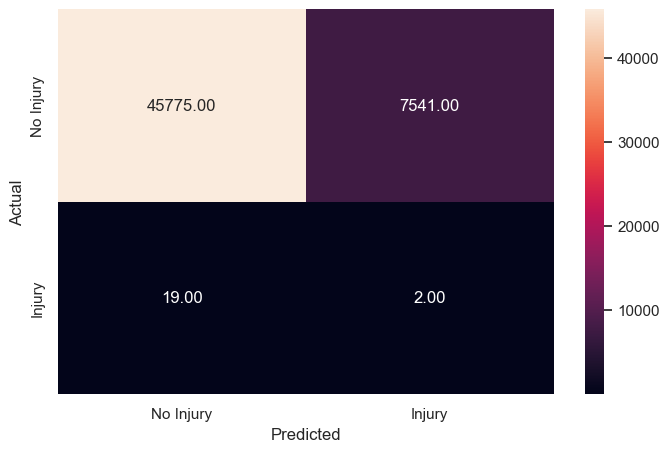

In [64]:
# Checking the performance of K-NN model on the training data
y_pred_test_knn = knn.predict(X_test_scaled)

knn_test = metrics_score(y_test, y_pred_test_knn,'KNN')

In [65]:
results_testset_nm = knn_test
results_testset_nm

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.85826,0.904762,0.095238,0.000265,0.000529,0.476899


### Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.42      0.59     53316
           1       0.00      0.71      0.00        21

    accuracy                           0.42     53337
   macro avg       0.50      0.57      0.30     53337
weighted avg       1.00      0.42      0.59     53337



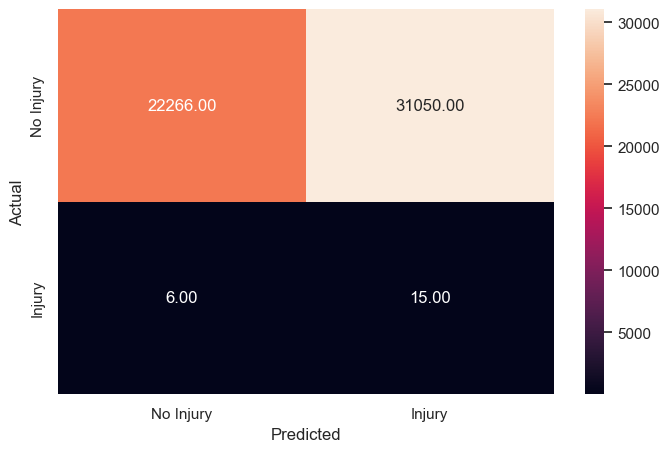

In [66]:
lg = LogisticRegression(random_state=0).fit(X_train_scaled_nm, y_train_nm)
y_pred_log = lg.predict(X_test_scaled)

lg_test = metrics_score(y_test,y_pred_log,'Logistic Regression')

In [67]:
results_testset_nm = results_testset_nm.append(lg_test, ignore_index = True)
results_testset_nm

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/188821622.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_nm = results_testset_nm.append(lg_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.85826,0.904762,0.095238,0.000265,0.000529,0.476899
1,Logistic Regression,0.41774,0.285714,0.714286,0.000483,0.000965,0.565954


### Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
dt = DecisionTreeClassifier(random_state = 1)

# Train Decision Tree Classifer
dt = dt.fit(X_train_nm,y_train_nm)

#Predict the response for test dataset
y_pred_dt = dt.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.09      0.16     53316
           1       0.00      0.71      0.00        21

    accuracy                           0.09     53337
   macro avg       0.50      0.40      0.08     53337
weighted avg       1.00      0.09      0.16     53337



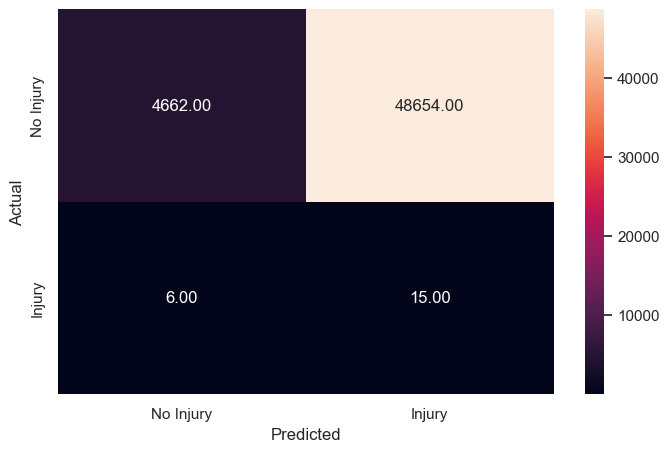

In [69]:
dt_test = metrics_score(y_test,y_pred_dt,'Decision Tree')

In [70]:
results_testset_nm= results_testset_nm.append(dt_test, ignore_index = True)
results_testset_nm

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/2185216159.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_nm= results_testset_nm.append(dt_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.858260,0.904762,0.095238,0.000265,0.000529,0.476899
1,Logistic Regression,0.417740,0.285714,0.714286,0.000483,0.000965,0.565954
2,Decision Tree,0.087688,0.285714,0.714286,0.000308,0.000616,0.400863


/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

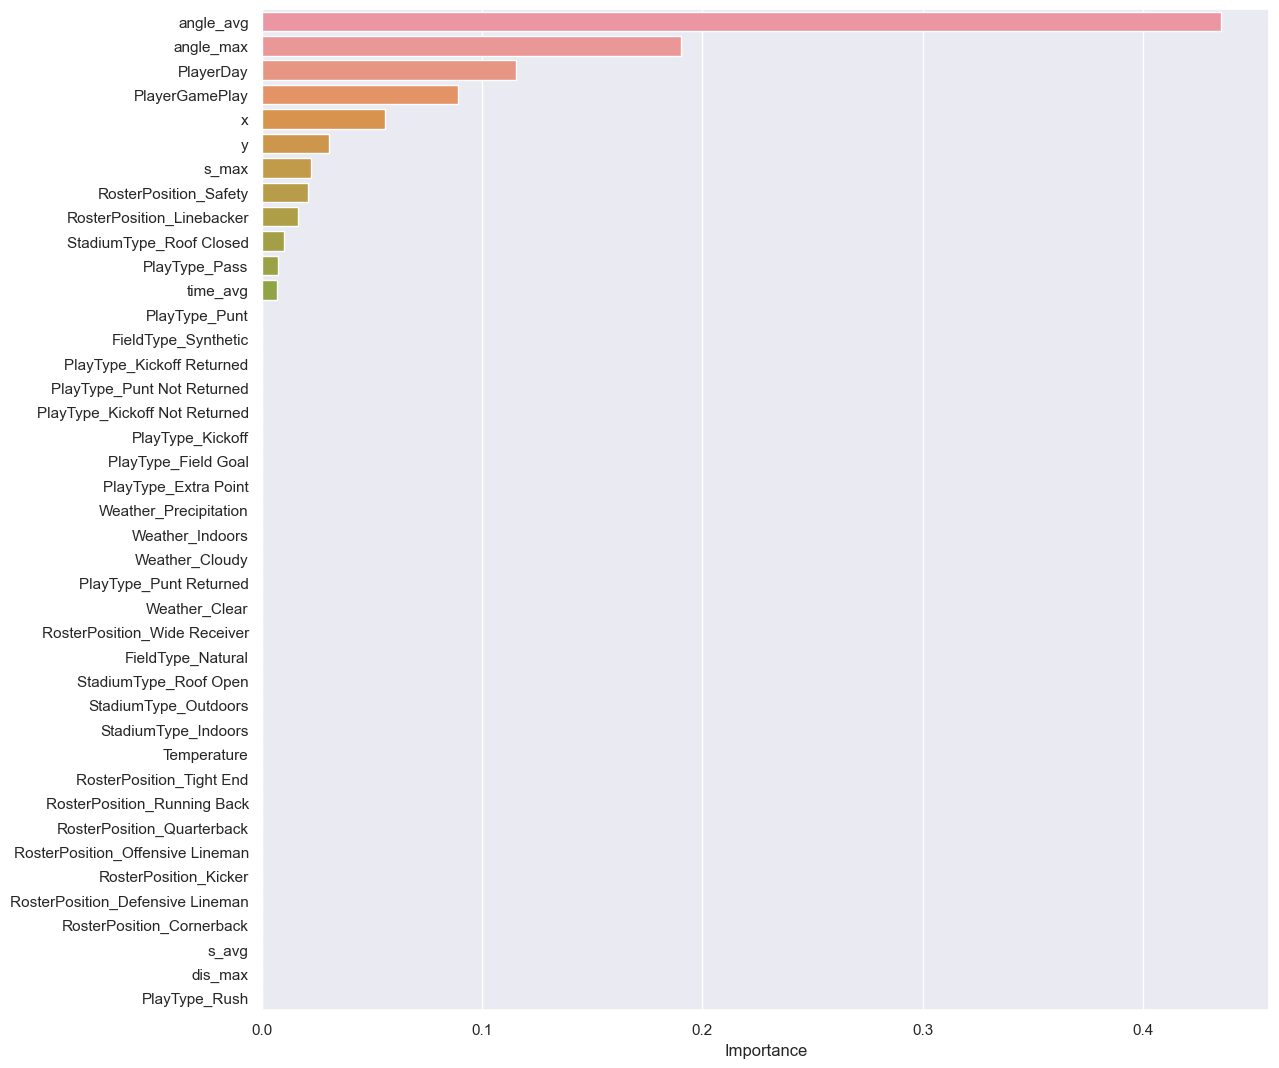

In [71]:
# Plot the feature importance

importances = dt.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance,importance_df.index)

In [72]:
from sklearn.metrics import make_scorer
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 7), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fitting the grid search on the train data
gridCV = gridCV.fit(X_train_nm, y_train_nm)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(X_train_nm, y_train_nm)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.06      0.11     53316
           1       0.00      0.95      0.00        21

    accuracy                           0.06     53337
   macro avg       0.50      0.51      0.06     53337
weighted avg       1.00      0.06      0.11     53337



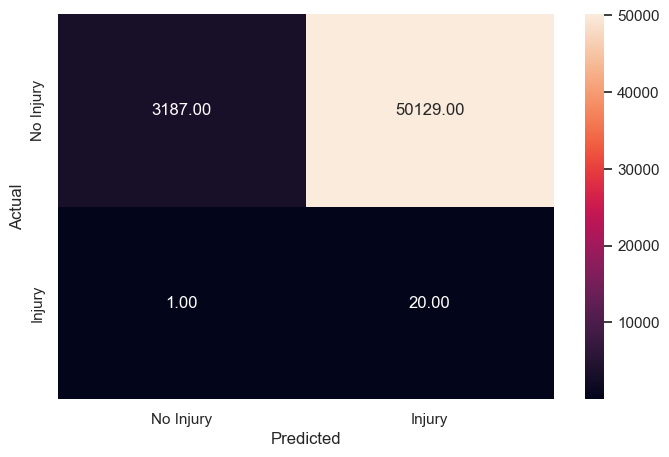

In [73]:
# Checking performance on the test dataset
y_pred_dt_tuned = dtree_estimator.predict(X_test)

dt_test_tuned = metrics_score(y_test, y_pred_dt_tuned,'Decision Tree Tuned')

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

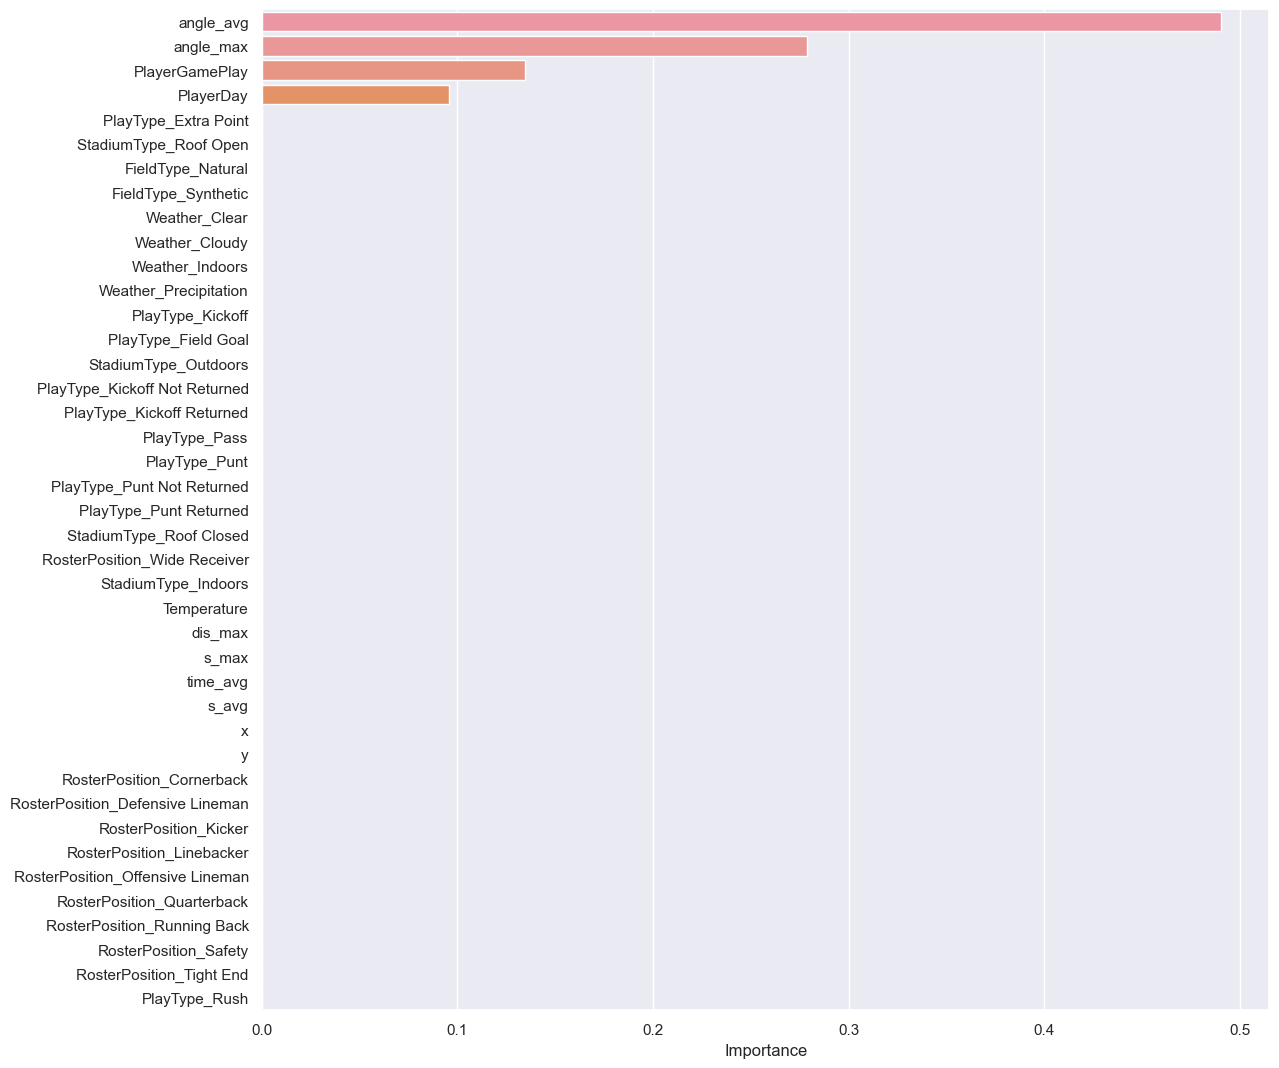

In [74]:
# Plot the feature importance

importances = dtree_estimator.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance,importance_df.index)

In [75]:
results_testset_nm = results_testset_nm.append(dt_test_tuned, ignore_index = True)
results_testset_nm

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1304747294.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_nm = results_testset_nm.append(dt_test_tuned, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.858260,0.904762,0.095238,0.000265,0.000529,0.476899
1,Logistic Regression,0.417740,0.285714,0.714286,0.000483,0.000965,0.565954
2,Decision Tree,0.087688,0.285714,0.714286,0.000308,0.000616,0.400863
3,Decision Tree Tuned,0.060127,0.047619,0.952381,0.000399,0.000797,0.506078


### Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifer object
rf = RandomForestClassifier(random_state = 1)

# Train random forest
rf.fit(X_train_nm,y_train_nm)  

#Predict the response for test dataset
y_pred_rf = rf.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.07      0.14     53316
           1       0.00      0.95      0.00        21

    accuracy                           0.07     53337
   macro avg       0.50      0.51      0.07     53337
weighted avg       1.00      0.07      0.14     53337



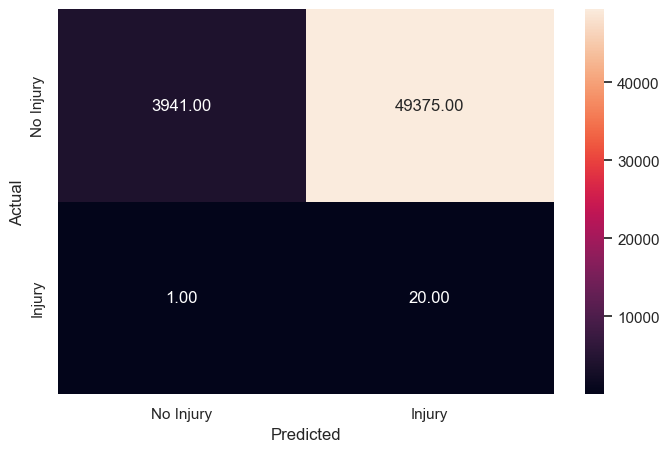

In [77]:
rf_test = metrics_score(y_test,y_pred_rf,'Random Forest')

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

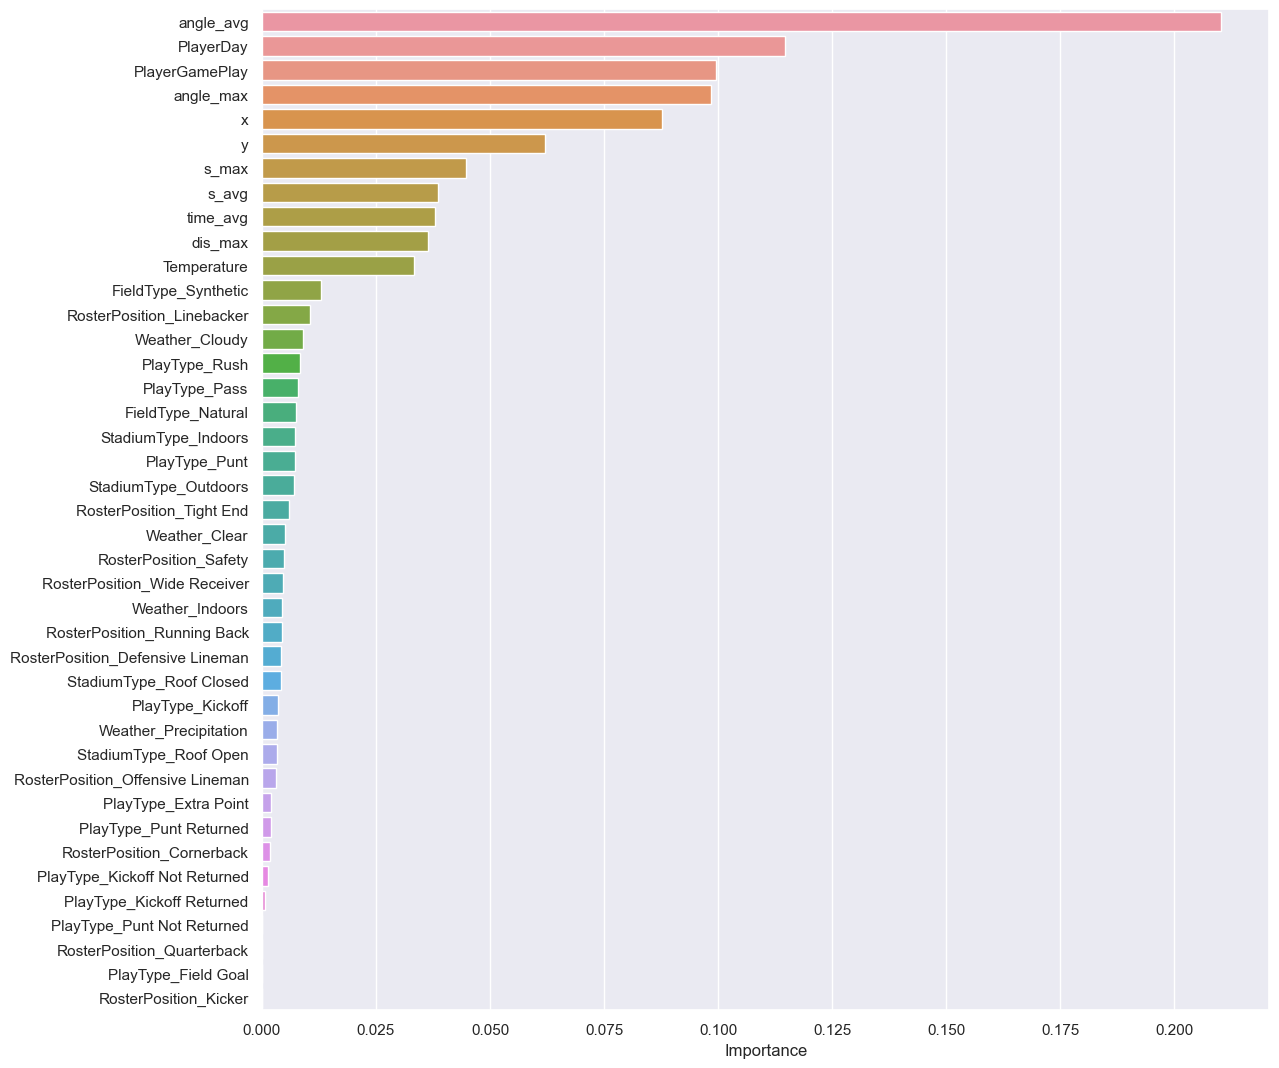

In [78]:
# Plot the feature importance

importances = rf.feature_importances_

columns = X.columns

importance_rf = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_rf.Importance,importance_rf.index)

In [79]:
results_testset_nm = results_testset_nm.append(rf_test, ignore_index = True)
results_testset_nm

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/3425590557.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_nm = results_testset_nm.append(rf_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.858260,0.904762,0.095238,0.000265,0.000529,0.476899
1,Logistic Regression,0.417740,0.285714,0.714286,0.000483,0.000965,0.565954
2,Decision Tree,0.087688,0.285714,0.714286,0.000308,0.000616,0.400863
3,Decision Tree Tuned,0.060127,0.047619,0.952381,0.000399,0.000797,0.506078
4,Random Forest,0.074264,0.047619,0.952381,0.000405,0.000809,0.513149


In [80]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(random_state = 1)

# Grid of parameters to choose from
params_rf = {  
        "n_estimators": [100, 250, 500],
        "min_samples_leaf": np.arange(1, 4, 1),
        "max_features": [0.7, 0.9, 'auto'],
}


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(X_train_nm, y_train_nm)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

rf_estimator_tuned.fit(X_train_nm, y_train_nm)

RandomForestClassifier(max_features=0.7, n_estimators=250, random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.05      0.09     53316
           1       0.00      0.90      0.00        21

    accuracy                           0.05     53337
   macro avg       0.50      0.48      0.05     53337
weighted avg       1.00      0.05      0.09     53337



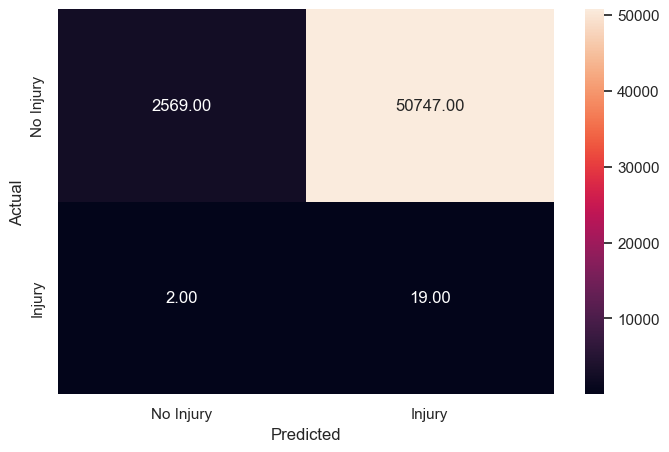

In [81]:
# Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(X_test)

rf_test_tuned = metrics_score(y_test, y_pred_train_rf_tuned,"Random Forest Tuned")

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

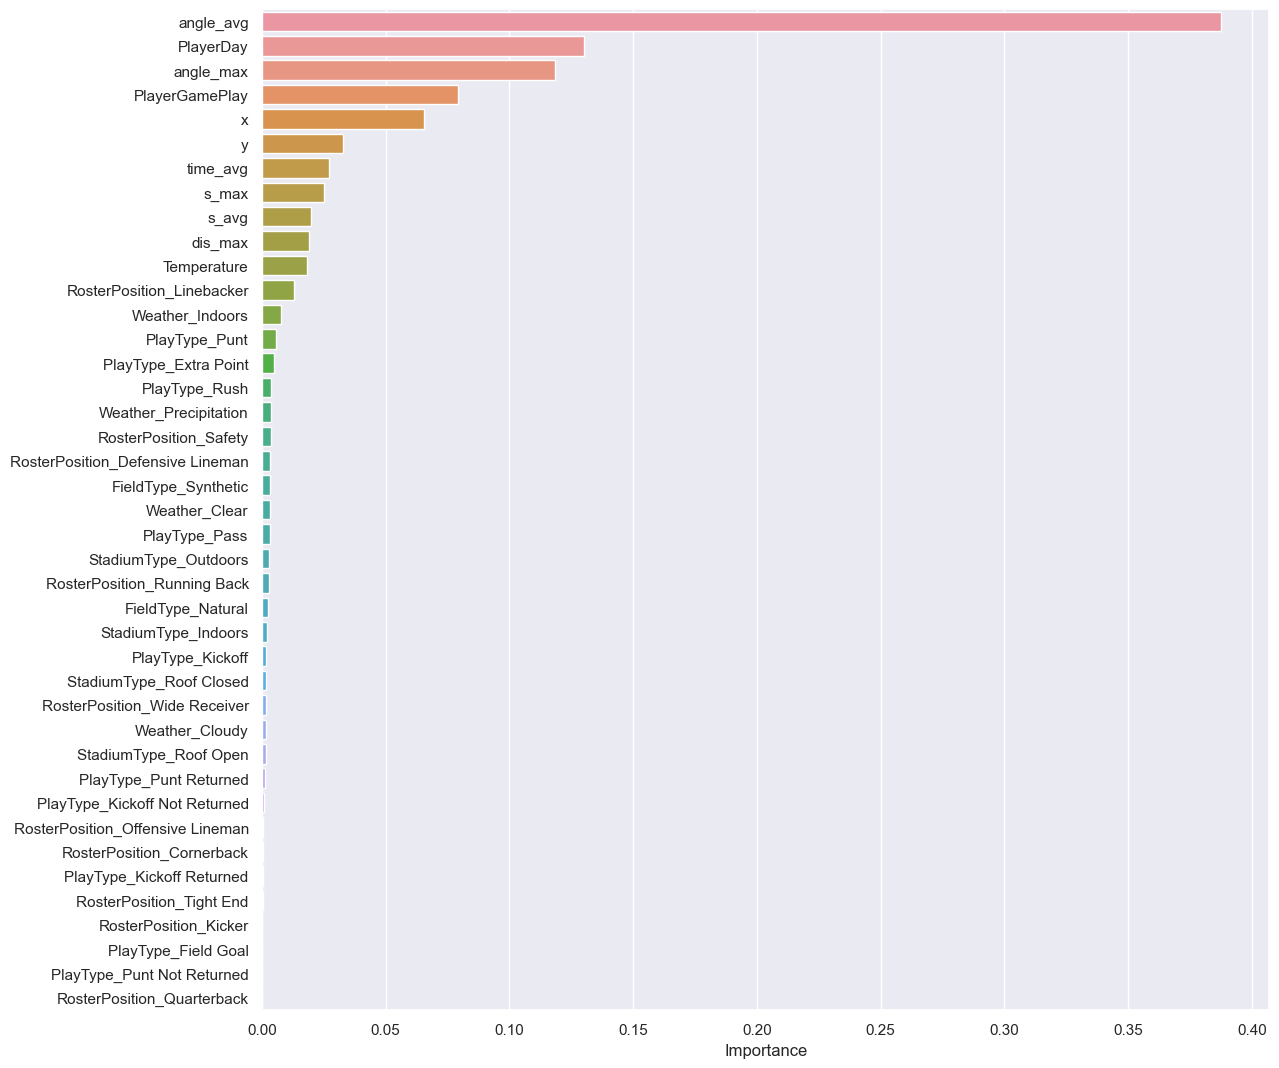

In [82]:
# Plot the feature importance

importances = rf_estimator_tuned.feature_importances_

columns = X.columns

importance_rf = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_rf.Importance,importance_rf.index)

In [83]:
results_testset_nm = results_testset_nm.append(rf_test_tuned, ignore_index = True)
results_testset_nm

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1152753410.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_nm = results_testset_nm.append(rf_test_tuned, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.858260,0.904762,0.095238,0.000265,0.000529,0.476899
1,Logistic Regression,0.417740,0.285714,0.714286,0.000483,0.000965,0.565954
2,Decision Tree,0.087688,0.285714,0.714286,0.000308,0.000616,0.400863
3,Decision Tree Tuned,0.060127,0.047619,0.952381,0.000399,0.000797,0.506078
4,Random Forest,0.074264,0.047619,0.952381,0.000405,0.000809,0.513149
5,Random Forest Tuned,0.048522,0.095238,0.904762,0.000374,0.000748,0.476473


### XG Boost

              precision    recall  f1-score   support

           0       1.00      0.08      0.14     53316
           1       0.00      0.90      0.00        21

    accuracy                           0.08     53337
   macro avg       0.50      0.49      0.07     53337
weighted avg       1.00      0.08      0.14     53337



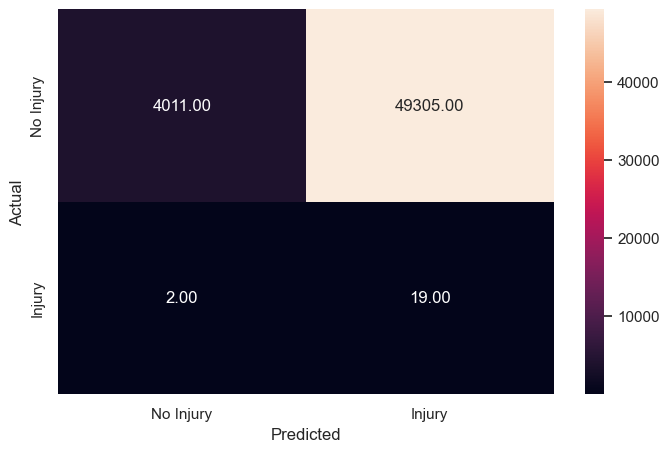

In [84]:
# Importing the XGBReressor from the xgboost
from xgboost import XGBClassifier

# XGBoost Regressor
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Fitting the model
xgb.fit(X_train_nm,y_train_nm)

# Checking performance on the training data
y_pred_test_xg = xgb.predict(X_test)

xg_test = metrics_score(y_test,y_pred_test_xg,'XGBoost')

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

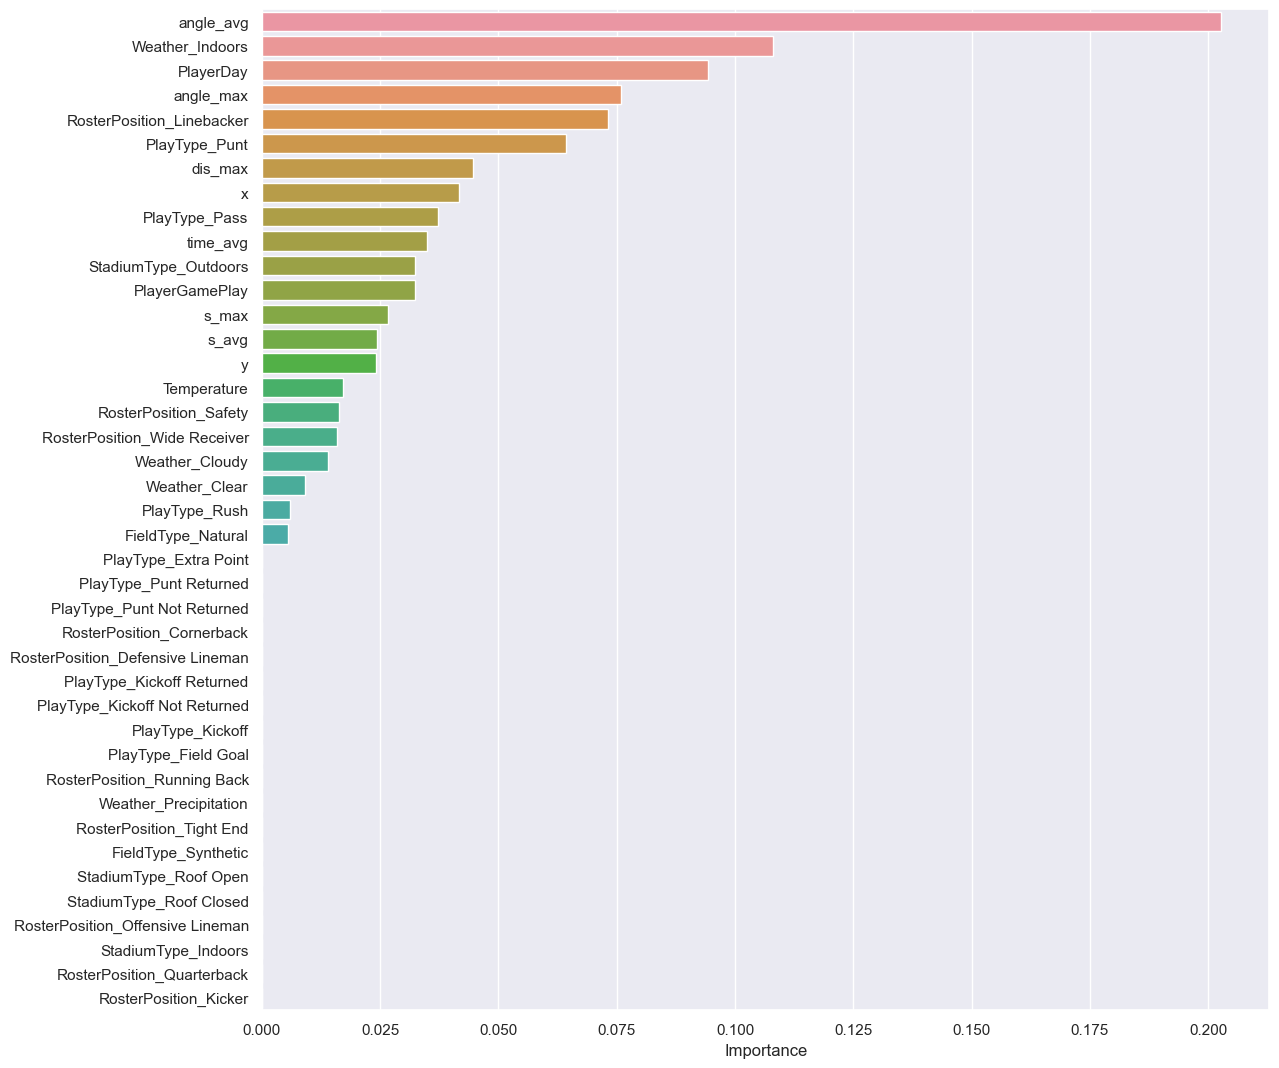

In [85]:
# Plot the feature importance

importances = xgb.feature_importances_

columns = X.columns

importance_rf = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_rf.Importance,importance_rf.index)

In [86]:
results_testset_nm = results_testset_nm.append(xg_test, ignore_index = True)
results_testset_nm

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/3540110178.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_nm = results_testset_nm.append(xg_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.858260,0.904762,0.095238,0.000265,0.000529,0.476899
1,Logistic Regression,0.417740,0.285714,0.714286,0.000483,0.000965,0.565954
2,Decision Tree,0.087688,0.285714,0.714286,0.000308,0.000616,0.400863
3,Decision Tree Tuned,0.060127,0.047619,0.952381,0.000399,0.000797,0.506078
4,Random Forest,0.074264,0.047619,0.952381,0.000405,0.000809,0.513149
5,Random Forest Tuned,0.048522,0.095238,0.904762,0.000374,0.000748,0.476473
6,XGBoost,0.075557,0.095238,0.904762,0.000385,0.000770,0.489996


### AdaBoost

              precision    recall  f1-score   support

           0       1.00      0.09      0.17     53316
           1       0.00      0.95      0.00        21

    accuracy                           0.09     53337
   macro avg       0.50      0.52      0.08     53337
weighted avg       1.00      0.09      0.17     53337



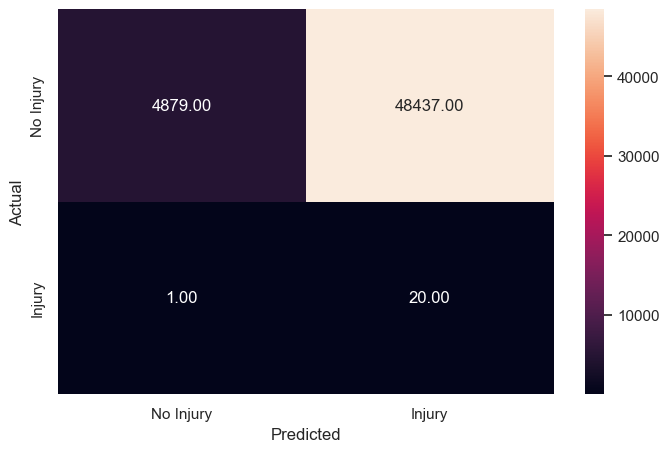

In [87]:
# Importing the Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
abc.fit(X_train_nm, y_train_nm)

#Predict the response for test dataset
y_pred = abc.predict(X_test)

a_test = metrics_score(y_test,y_pred,'AdaBoost')

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

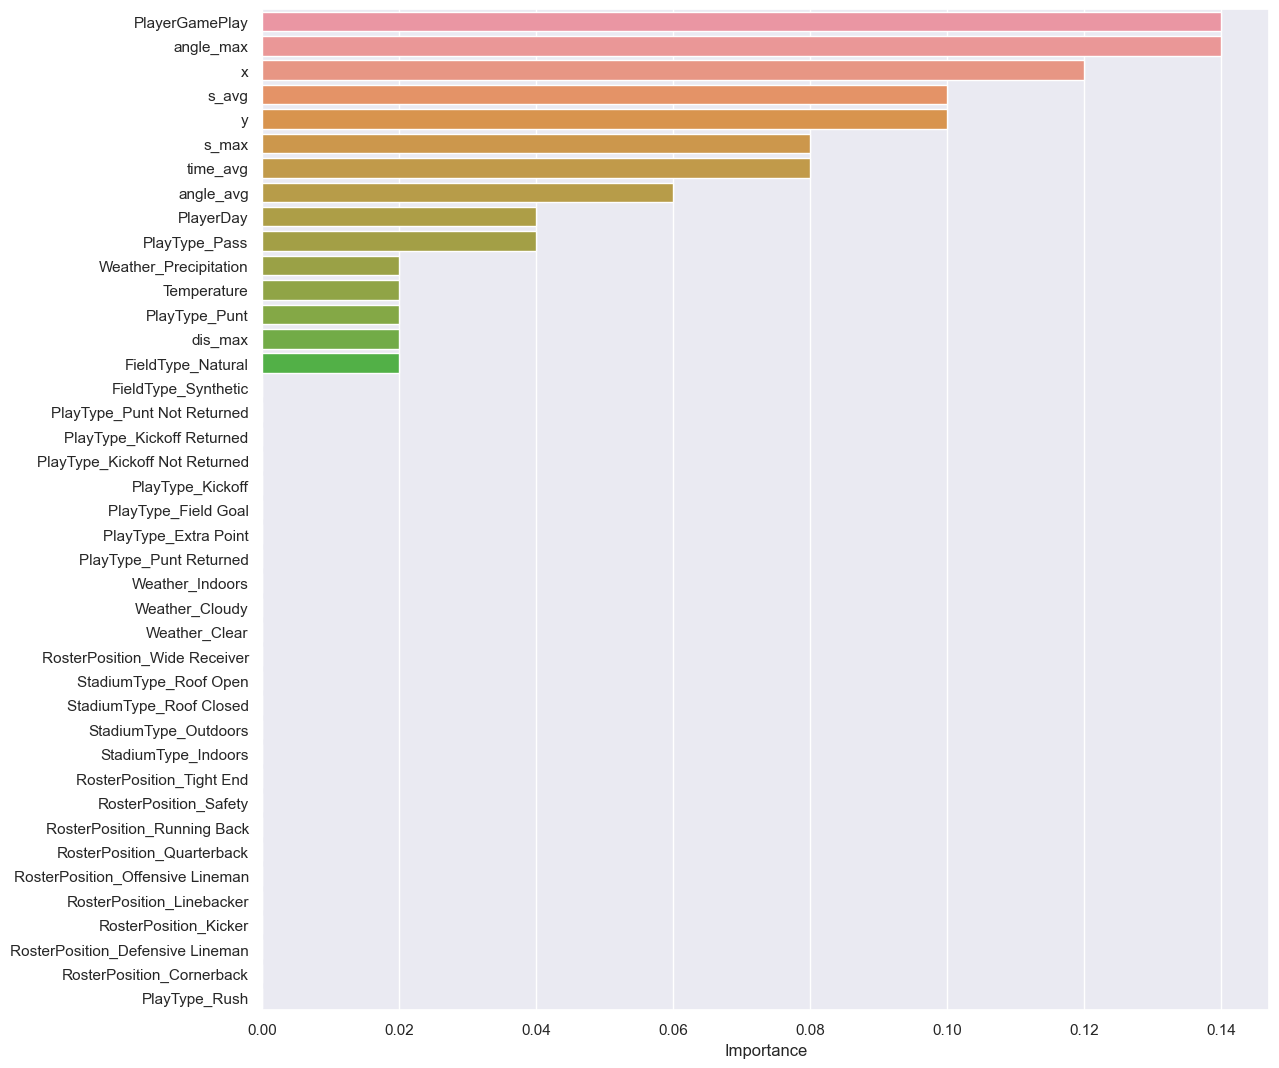

In [88]:
# Plot the feature importance

importances = abc.feature_importances_

columns = X.columns

importance_rf = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_rf.Importance,importance_rf.index)

In [89]:
results_testset_nm = results_testset_nm.append(a_test, ignore_index = True)
results_testset_nm

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/2072147401.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_nm = results_testset_nm.append(a_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.858260,0.904762,0.095238,0.000265,0.000529,0.476899
1,Logistic Regression,0.417740,0.285714,0.714286,0.000483,0.000965,0.565954
2,Decision Tree,0.087688,0.285714,0.714286,0.000308,0.000616,0.400863
3,Decision Tree Tuned,0.060127,0.047619,0.952381,0.000399,0.000797,0.506078
4,Random Forest,0.074264,0.047619,0.952381,0.000405,0.000809,0.513149
5,Random Forest Tuned,0.048522,0.095238,0.904762,0.000374,0.000748,0.476473
6,XGBoost,0.075557,0.095238,0.904762,0.000385,0.000770,0.489996
7,AdaBoost,0.091850,0.047619,0.952381,0.000413,0.000825,0.521946


## Build Models without Data Augmentation

### KNN

In [90]:
# Define K-NN model

knn = KNeighborsClassifier(n_neighbors = 4)

In [91]:
# Fitting data to the K-NN model

knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=4)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

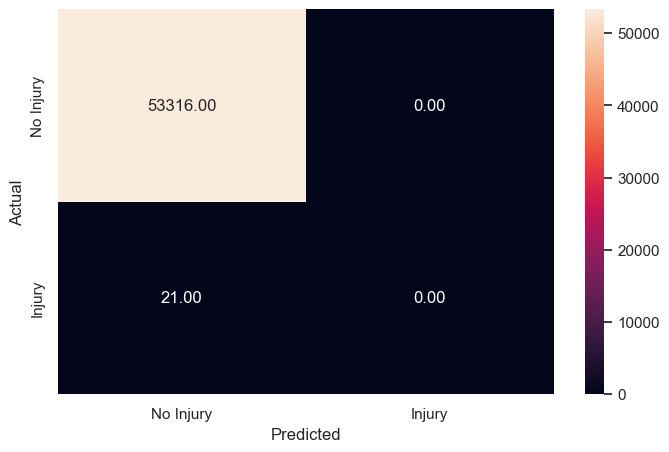

In [92]:
# Checking the performance of K-NN model on the training data
y_pred_test_knn = knn.predict(X_test_scaled)

knn_test = metrics_score(y_test, y_pred_test_knn,'KNN')

In [93]:
results_testset = knn_test
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999606,1.0,0.0,0.0,0.0,0.5


### Logistic Regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

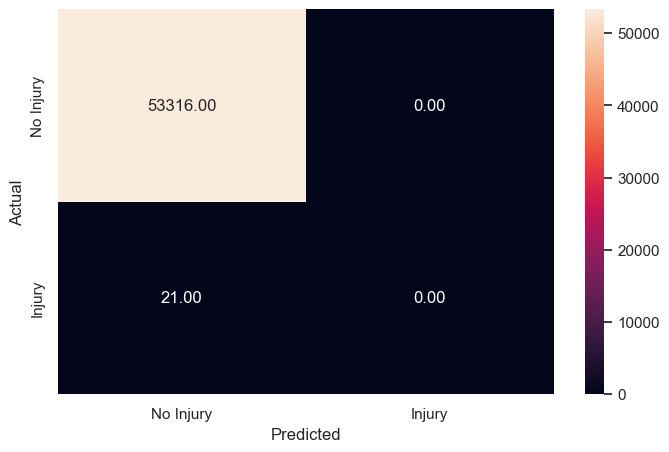

In [94]:
lg = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)
y_pred_log = lg.predict(X_test_scaled)

lg_test = metrics_score(y_test,y_pred_log,'Logistic Regression')

In [95]:
results_testset = results_testset.append(lg_test, ignore_index = True)
results_testset

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1450855436.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset = results_testset.append(lg_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999606,1.0,0.0,0.0,0.0,0.5
1,Logistic Regression,0.999606,1.0,0.0,0.0,0.0,0.5


### Decision Tree

In [96]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(random_state = 1)

# Train Decision Tree Classifer
dt = dt.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_dt = dt.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



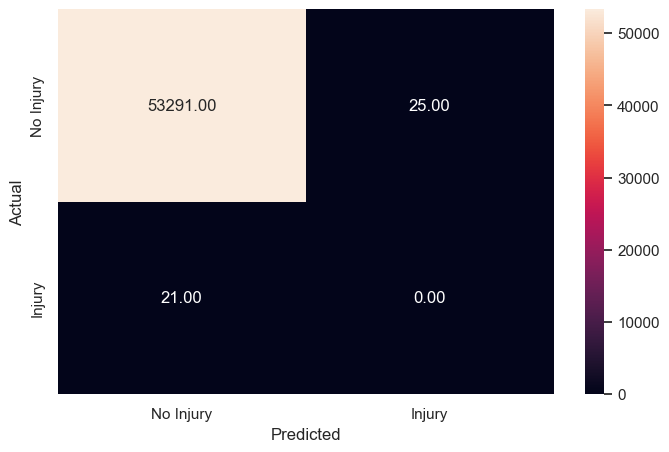

In [97]:
dt_test = metrics_score(y_test,y_pred_dt,'Decision Tree')

In [98]:
results_testset = results_testset.append(dt_test, ignore_index = True)
results_testset

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/3339140775.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset = results_testset.append(dt_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999606,1.0,0.0,0.0,0.0,0.500000
1,Logistic Regression,0.999606,1.0,0.0,0.0,0.0,0.500000
2,Decision Tree,0.999138,1.0,0.0,0.0,0.0,0.499766


In [99]:
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 7), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fitting the grid search on the train data
gridCV = gridCV.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

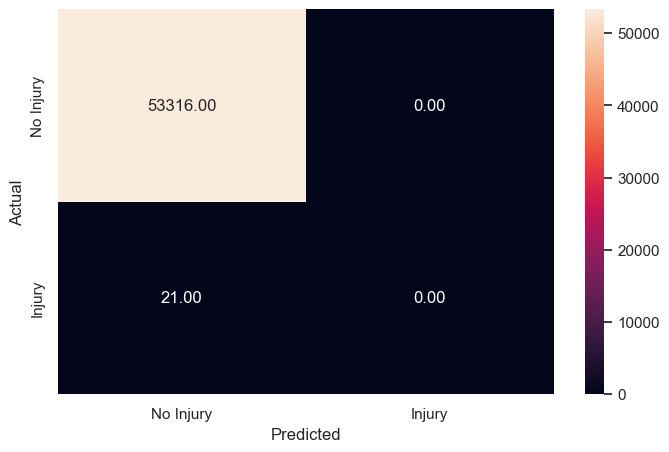

In [100]:
# Checking performance on the test dataset
y_pred_dt_tuned = dtree_estimator.predict(X_test)

dt_test_tuned = metrics_score(y_test, y_pred_dt_tuned,'Decision Tree Tuned')

In [101]:
results_testset = results_testset.append(dt_test_tuned, ignore_index = True)
results_testset

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/324954914.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset = results_testset.append(dt_test_tuned, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999606,1.0,0.0,0.0,0.0,0.500000
1,Logistic Regression,0.999606,1.0,0.0,0.0,0.0,0.500000
2,Decision Tree,0.999138,1.0,0.0,0.0,0.0,0.499766
3,Decision Tree Tuned,0.999606,1.0,0.0,0.0,0.0,0.500000


/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

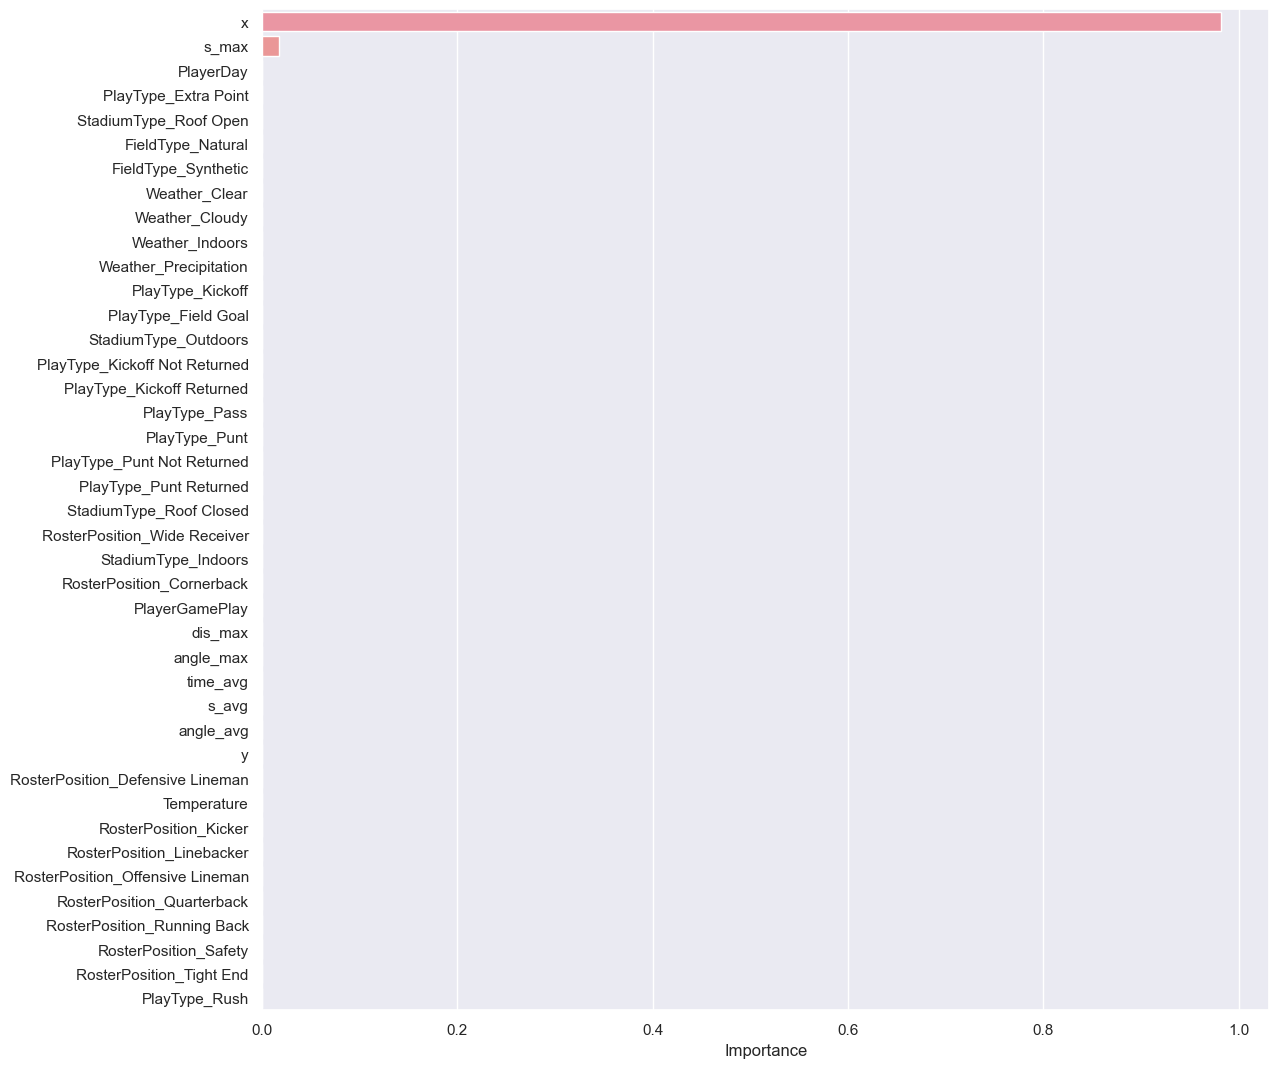

In [102]:
# Plot the feature importance

importances = dtree_estimator.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance,importance_df.index)

### Random Forest

In [103]:
# Create Random Forest classifer object
rf = RandomForestClassifier(random_state = 1)

# Train random forest
rf.fit(X_train,y_train)  

#Predict the response for test dataset
y_pred_rf = rf.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

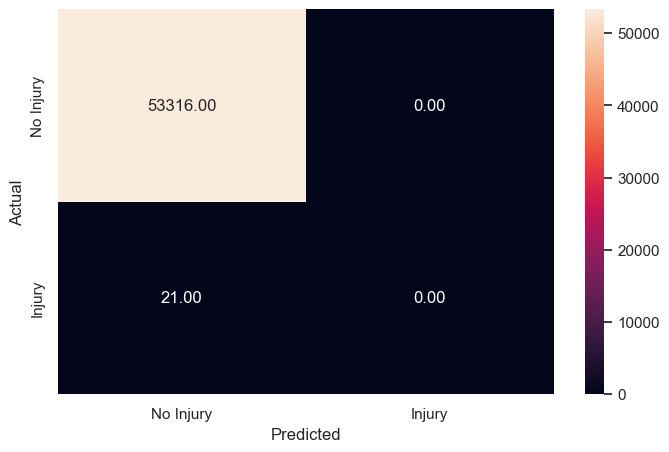

In [104]:
rf_test = metrics_score(y_test,y_pred_rf,'Random Forest')

In [105]:
results_testset = results_testset.append(rf_test, ignore_index = True)
results_testset

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/2571374962.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset = results_testset.append(rf_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999606,1.0,0.0,0.0,0.0,0.500000
1,Logistic Regression,0.999606,1.0,0.0,0.0,0.0,0.500000
2,Decision Tree,0.999138,1.0,0.0,0.0,0.0,0.499766
3,Decision Tree Tuned,0.999606,1.0,0.0,0.0,0.0,0.500000
4,Random Forest,0.999606,1.0,0.0,0.0,0.0,0.500000


In [106]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(random_state = 1)

# Grid of parameters to choose from
params_rf = {  
        "n_estimators": [100, 250, 500],
        "min_samples_leaf": np.arange(1, 4, 1),
        "max_features": [0.7, 0.9, 'auto'],
}


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features=0.7, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

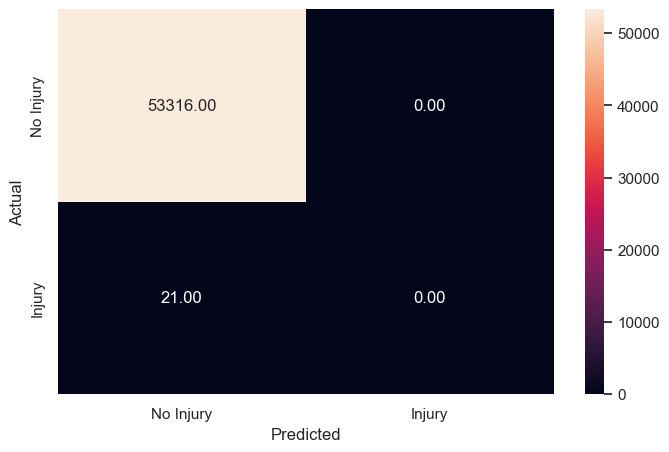

In [107]:
# Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(X_test)

rf_test_tuned = metrics_score(y_test, y_pred_train_rf_tuned,"Random Forest Tuned")

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

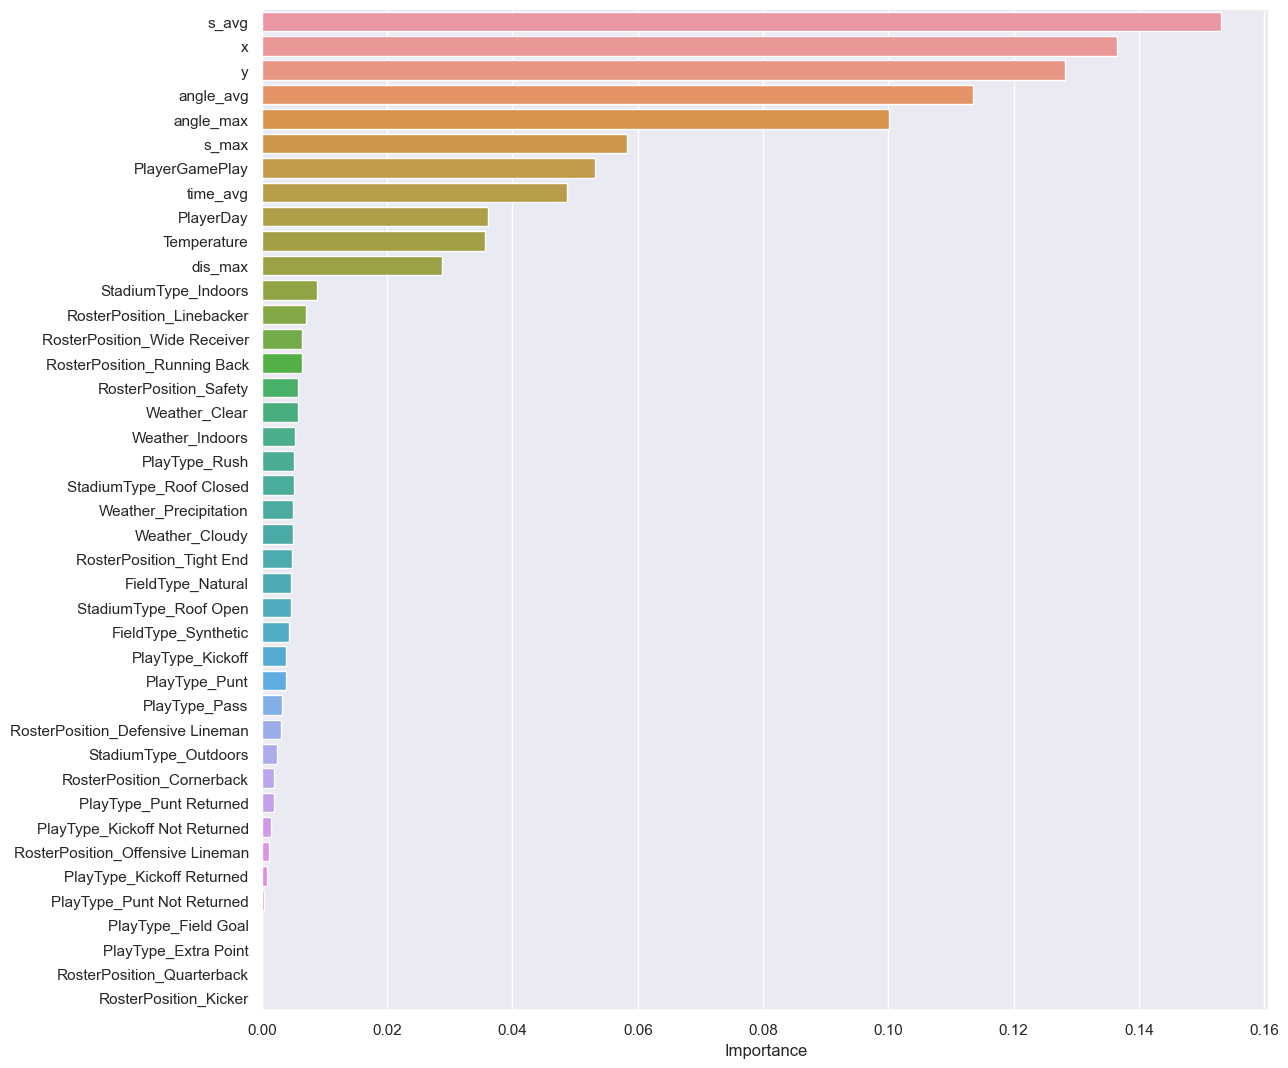

In [108]:
# Plot the feature importance

importances = rf_estimator_tuned.feature_importances_

columns = X.columns

importance_rf = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_rf.Importance,importance_rf.index)

In [109]:
results_testset = results_testset.append(rf_test_tuned, ignore_index = True)
results_testset

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/2585287212.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset = results_testset.append(rf_test_tuned, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999606,1.0,0.0,0.0,0.0,0.500000
1,Logistic Regression,0.999606,1.0,0.0,0.0,0.0,0.500000
2,Decision Tree,0.999138,1.0,0.0,0.0,0.0,0.499766
3,Decision Tree Tuned,0.999606,1.0,0.0,0.0,0.0,0.500000
4,Random Forest,0.999606,1.0,0.0,0.0,0.0,0.500000
5,Random Forest Tuned,0.999606,1.0,0.0,0.0,0.0,0.500000


### XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

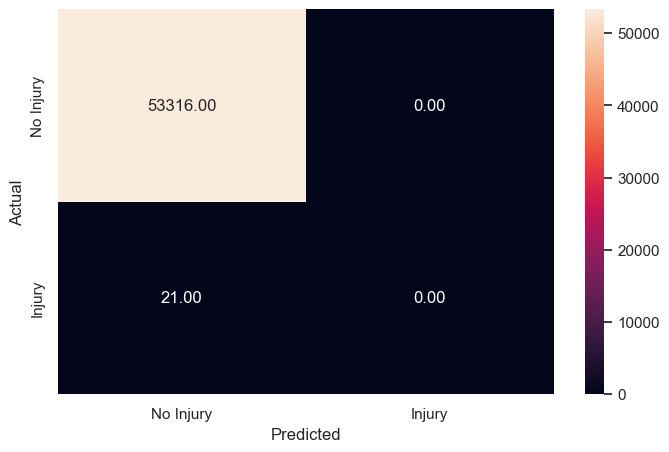

In [110]:
# XGBoost Classifier
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Fitting the model
xgb.fit(X_train,y_train)

# Checking performance on the training data
y_pred_test_xg = xgb.predict(X_test)

xg_test = metrics_score(y_test,y_pred_test_xg,'XGBoost')

In [111]:
results_testset = results_testset.append(xg_test, ignore_index = True)
results_testset

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/2945624961.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset = results_testset.append(xg_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999606,1.0,0.0,0.0,0.0,0.500000
1,Logistic Regression,0.999606,1.0,0.0,0.0,0.0,0.500000
2,Decision Tree,0.999138,1.0,0.0,0.0,0.0,0.499766
3,Decision Tree Tuned,0.999606,1.0,0.0,0.0,0.0,0.500000
4,Random Forest,0.999606,1.0,0.0,0.0,0.0,0.500000
5,Random Forest Tuned,0.999606,1.0,0.0,0.0,0.0,0.500000
6,XGBoost,0.999606,1.0,0.0,0.0,0.0,0.500000


### AdaBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

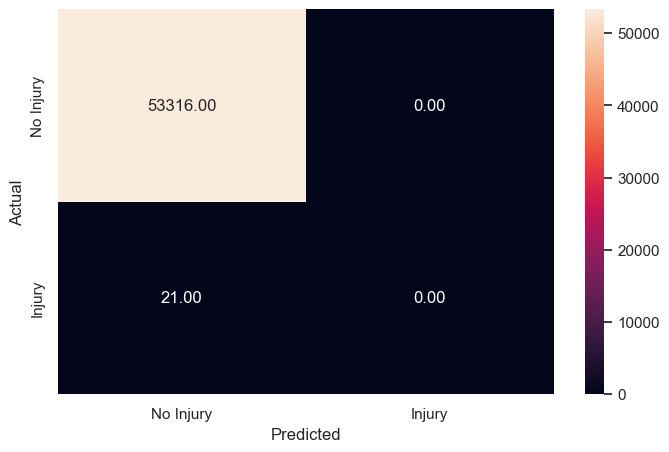

In [112]:
# Importing the Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = abc.predict(X_test)

a_test = metrics_score(y_test,y_pred,'AdaBoost')

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

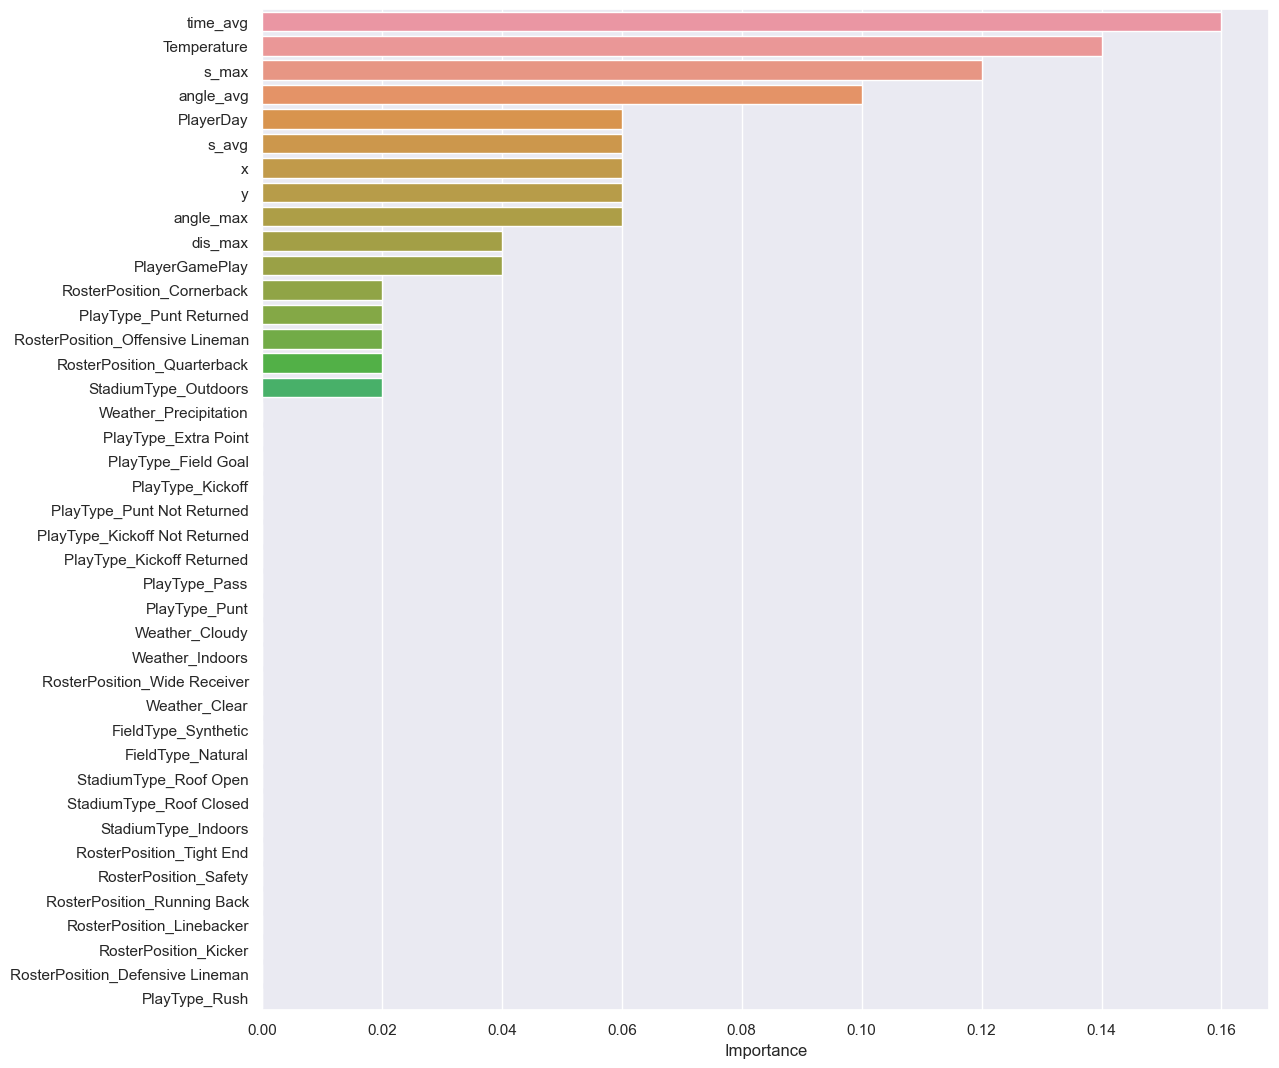

In [113]:
# Plot the feature importance

importances = abc.feature_importances_

columns = X.columns

importance_rf = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_rf.Importance,importance_rf.index)

In [114]:
results_testset = results_testset.append(a_test, ignore_index = True)
results_testset

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1787678150.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset = results_testset.append(a_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999606,1.0,0.0,0.0,0.0,0.500000
1,Logistic Regression,0.999606,1.0,0.0,0.0,0.0,0.500000
2,Decision Tree,0.999138,1.0,0.0,0.0,0.0,0.499766
3,Decision Tree Tuned,0.999606,1.0,0.0,0.0,0.0,0.500000
4,Random Forest,0.999606,1.0,0.0,0.0,0.0,0.500000
5,Random Forest Tuned,0.999606,1.0,0.0,0.0,0.0,0.500000
6,XGBoost,0.999606,1.0,0.0,0.0,0.0,0.500000
7,AdaBoost,0.999606,1.0,0.0,0.0,0.0,0.500000


## Build Models with Oversampled Data

### KNN

In [145]:
knn = KNeighborsClassifier(n_neighbors = 4)

In [146]:
# Fitting data to the K-NN model

knn.fit(X_train_scaled_a,y_train_a)

KNeighborsClassifier(n_neighbors=4)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



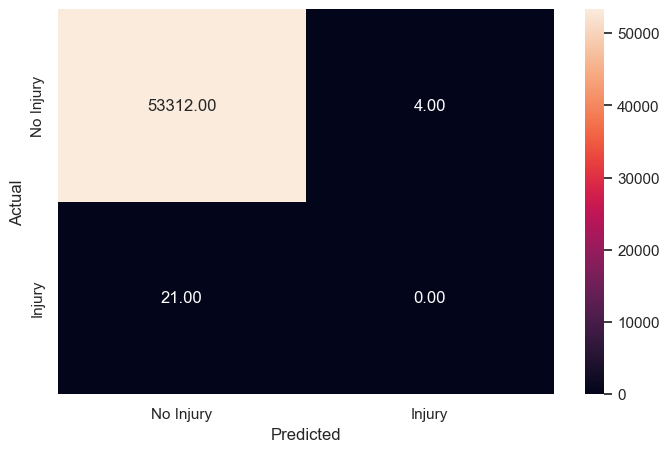

In [147]:
# Checking the performance of K-NN model on the training data
y_pred_test_knn = knn.predict(X_test_scaled)

knn_test = metrics_score(y_test, y_pred_test_knn,'KNN')

In [148]:
results_testset_a = knn_test
results_testset_a

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999531,1.0,0.0,0.0,0.0,0.499962


### Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.01      0.01     53316
           1       0.00      1.00      0.00        21

    accuracy                           0.01     53337
   macro avg       0.50      0.50      0.01     53337
weighted avg       1.00      0.01      0.01     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


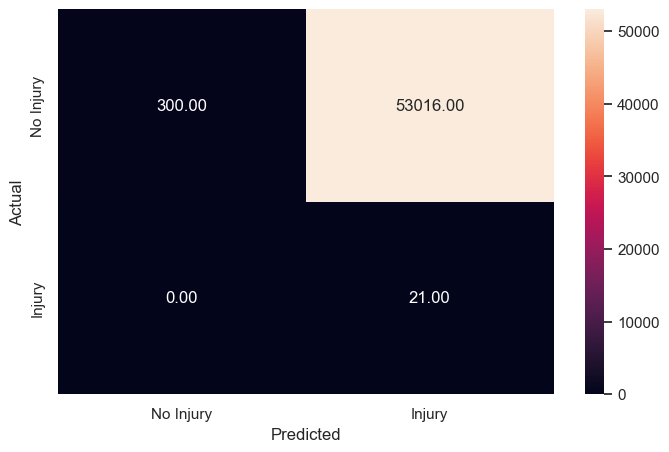

In [149]:
lg = LogisticRegression(random_state=0).fit(X_train_scaled_a, y_train_a)
y_pred_log = lg.predict(X_test_scaled)

lg_test = metrics_score(y_test,y_pred_log,'Logistic Regression')

In [150]:
results_testset_a = results_testset_a.append(lg_test, ignore_index = True)
results_testset_a

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1686202062.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_a = results_testset_a.append(lg_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999531,1.0,0.0,0.000000,0.000000,0.499962
1,Logistic Regression,0.006018,0.0,1.0,0.000396,0.000792,0.502813


### Decision Tree

In [151]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(random_state = 1)

# Train Decision Tree Classifer
dt = dt.fit(X_train_a,y_train_a)

#Predict the response for test dataset
y_pred_dt = dt.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



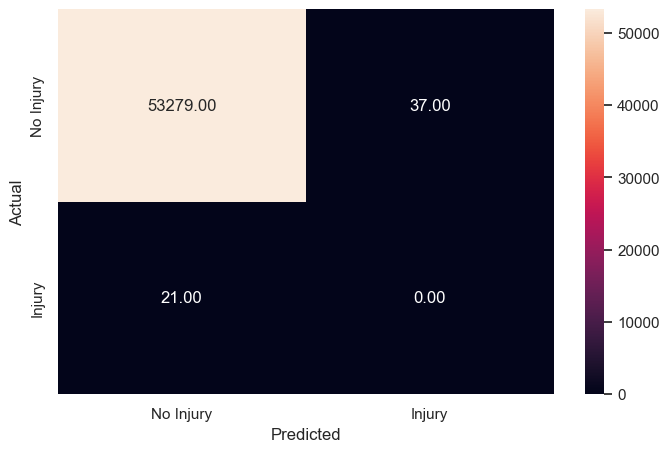

In [152]:
dt_test = metrics_score(y_test,y_pred_dt,'Decision Tree')

In [153]:
results_testset_a = results_testset_a.append(dt_test, ignore_index = True)
results_testset_a

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/922152678.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_a = results_testset_a.append(dt_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999531,1.0,0.0,0.000000,0.000000,0.499962
1,Logistic Regression,0.006018,0.0,1.0,0.000396,0.000792,0.502813
2,Decision Tree,0.998913,1.0,0.0,0.000000,0.000000,0.499653


/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

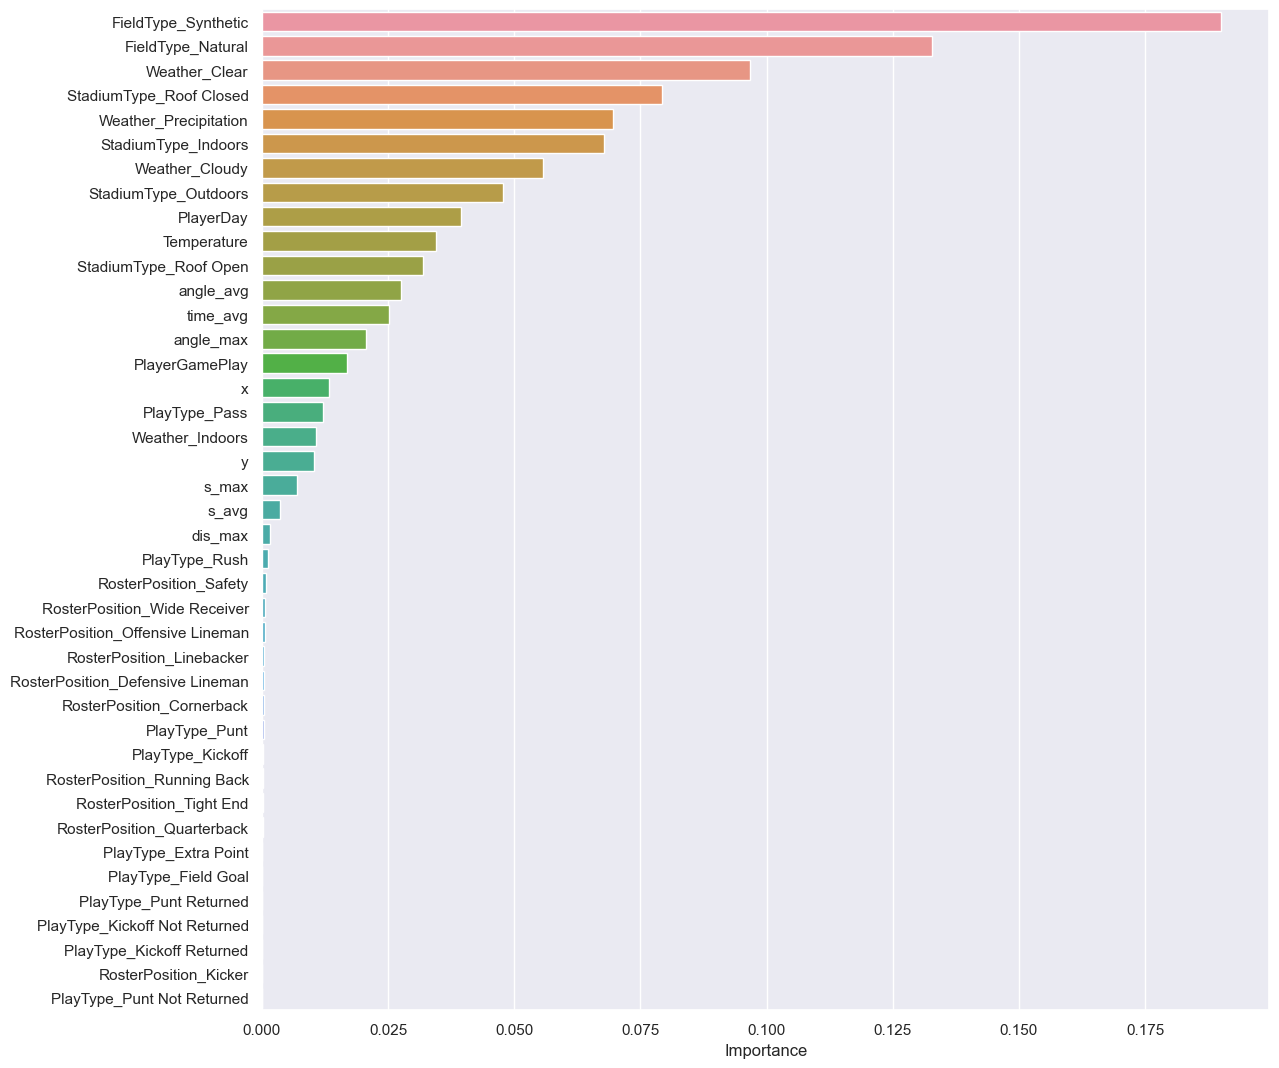

In [154]:
# Plot the feature importance

importances = dt.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance,importance_df.index)

### Random Forest

In [155]:
# Create Random Forest classifer object
rf = RandomForestClassifier(random_state = 1)

# Train random forest
rf.fit(X_train_a,y_train_a)  

#Predict the response for test dataset
y_pred_rf = rf.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

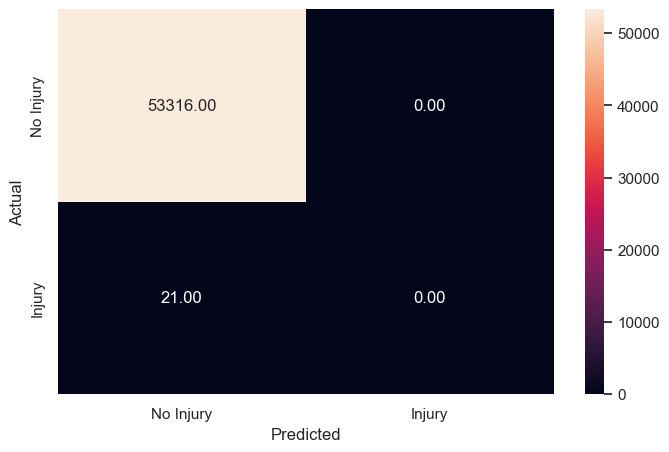

In [156]:
rf_test = metrics_score(y_test,y_pred_rf,'Random Forest')

In [157]:
results_testset_a = results_testset_a.append(rf_test, ignore_index = True)
results_testset_a

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/422953159.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_a = results_testset_a.append(rf_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999531,1.0,0.0,0.000000,0.000000,0.499962
1,Logistic Regression,0.006018,0.0,1.0,0.000396,0.000792,0.502813
2,Decision Tree,0.998913,1.0,0.0,0.000000,0.000000,0.499653
3,Random Forest,0.999606,1.0,0.0,0.000000,0.000000,0.500000


/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

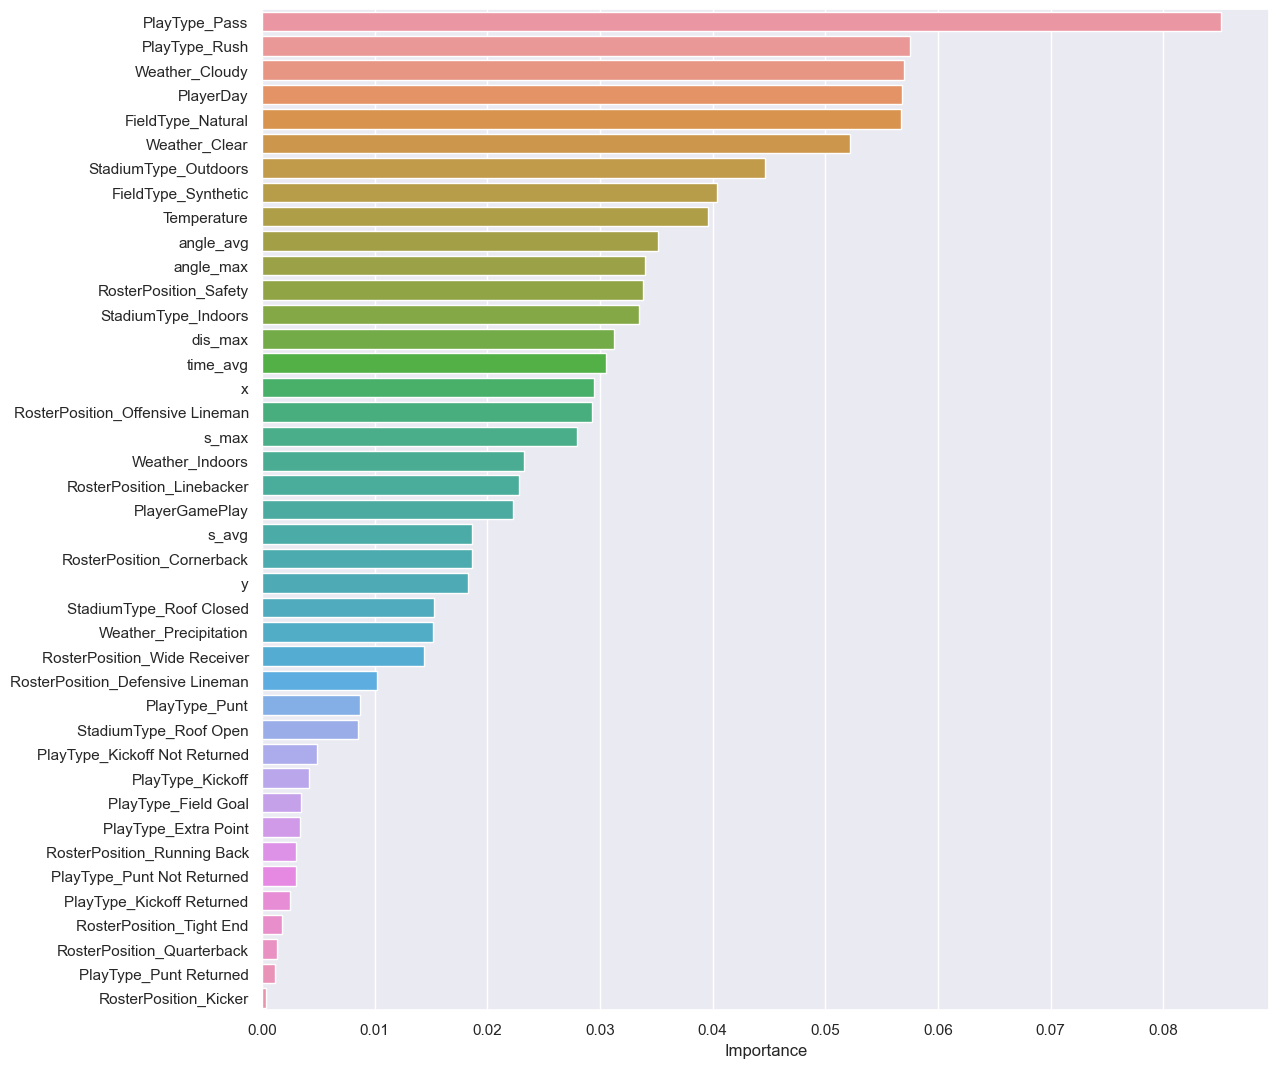

In [158]:
# Plot the feature importance

importances = rf.feature_importances_

columns = X.columns

importance_rf = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_rf.Importance,importance_rf.index)

### XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



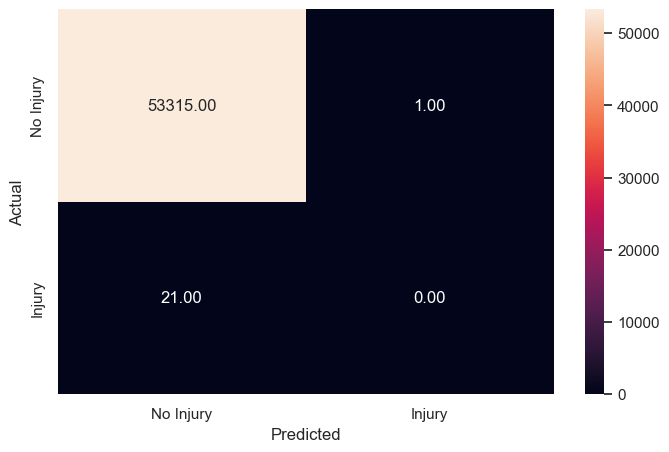

In [159]:
# XGBoost Classifier
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Fitting the model
xgb.fit(X_train_a,y_train_a)

# Checking performance on the training data
y_pred_test_xg = xgb.predict(X_test)

xg_test = metrics_score(y_test,y_pred_test_xg,'XGBoost')

In [160]:
results_testset_a = results_testset_a.append(xg_test, ignore_index = True)
results_testset_a

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1981156072.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_a = results_testset_a.append(xg_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999531,1.0,0.0,0.000000,0.000000,0.499962
1,Logistic Regression,0.006018,0.0,1.0,0.000396,0.000792,0.502813
2,Decision Tree,0.998913,1.0,0.0,0.000000,0.000000,0.499653
3,Random Forest,0.999606,1.0,0.0,0.000000,0.000000,0.500000
4,XGBoost,0.999588,1.0,0.0,0.000000,0.000000,0.499991


### AdaBoost

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           0.99     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      0.99      1.00     53337



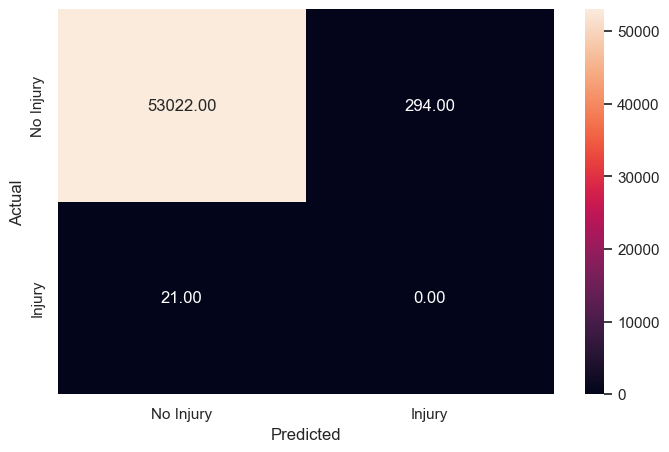

In [161]:
# Importing the Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
abc.fit(X_train_a, y_train_a)

#Predict the response for test dataset
y_pred = abc.predict(X_test)

a_test = metrics_score(y_test,y_pred,'AdaBoost')

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

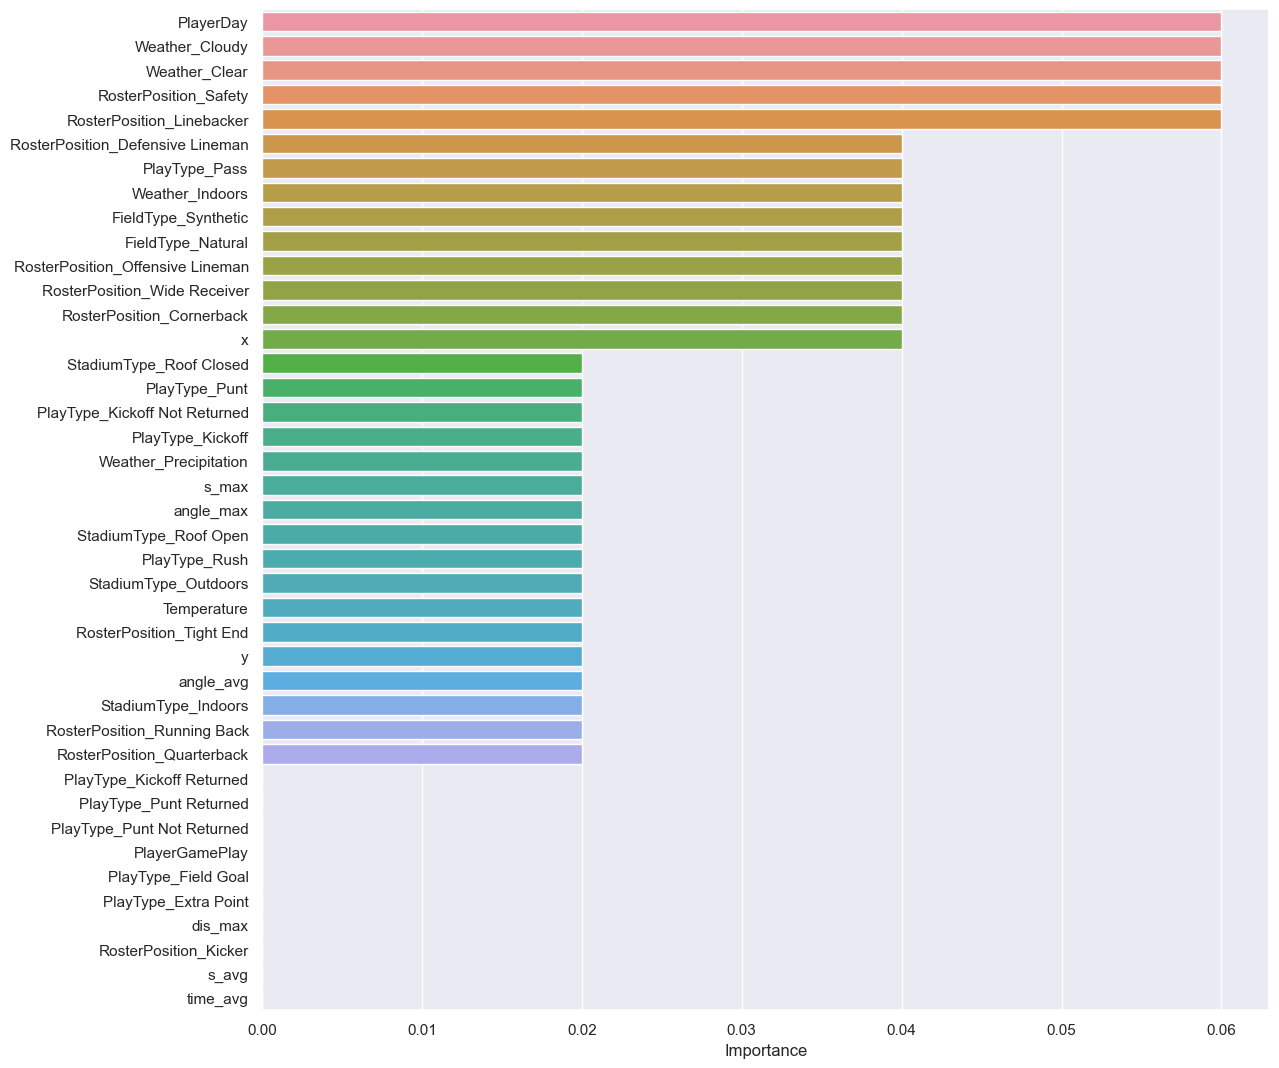

In [162]:
# Plot the feature importance

importances = abc.feature_importances_

columns = X.columns

importance_rf = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_rf.Importance,importance_rf.index)

In [163]:
results_testset_a = results_testset_a.append(a_test, ignore_index = True)
results_testset_a

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/2560296610.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_testset_a = results_testset_a.append(a_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,KNN,0.999531,1.0,0.0,0.000000,0.000000,0.499962
1,Logistic Regression,0.006018,0.0,1.0,0.000396,0.000792,0.502813
2,Decision Tree,0.998913,1.0,0.0,0.000000,0.000000,0.499653
3,Random Forest,0.999606,1.0,0.0,0.000000,0.000000,0.500000
4,XGBoost,0.999588,1.0,0.0,0.000000,0.000000,0.499991
5,AdaBoost,0.994094,1.0,0.0,0.000000,0.000000,0.497243


## Exploring Neural Networks

### Begin without Data Augmentation

In [164]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

model = Sequential([
    Dense(units=16, input_dim = 41,activation='relu'),
    BatchNormalization(),
    Dense(units=24,activation='relu'),
    Dense(24,activation='relu'),
    Dropout(0.5),
    Dense(24,activation='relu'),
    Dense(1,activation='sigmoid'),                        # binary classification injury or not
])

In [165]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                672       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 24)                408       
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_8 (Dense)             (None, 24)                600       
                                                      

In [166]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
12801/12801 [==============================] - 9s 643us/step - loss: 0.0068 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9998
Epoch 2/5
12801/12801 [==============================] - 8s 655us/step - loss: 0.0049 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 0.9998
Epoch 3/5
12801/12801 [==============================] - 8s 620us/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9998
Epoch 4/5
12801/12801 [==============================] - 8s 616us/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9998
Epoch 5/5
12801/12801 [==============================] - 8s 649us/step - loss: 0.0046 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9998


In [167]:
score = model.evaluate(X_test, y_test)
print(score)

1667/1667 [==============================] - 1s 460us/step - loss: 0.0040 - accuracy: 0.9996
[0.003965947311371565, 0.9996062517166138]


In [168]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 1s 324us/step


In [169]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

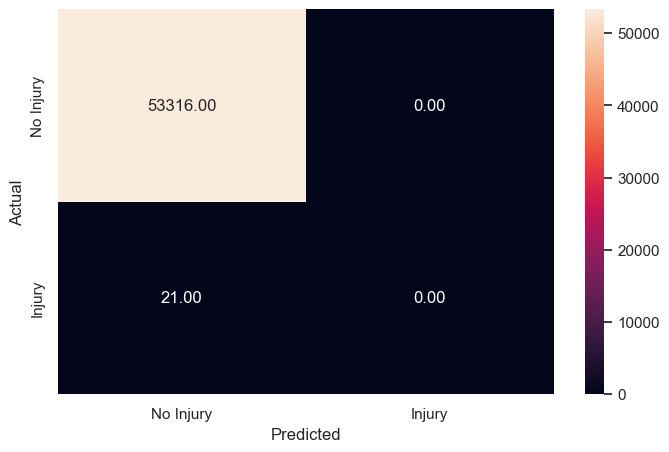

In [170]:
nn_test = metrics_score(y_test,y_pred_nn,'Basic Neural Network')

In [171]:
nn_testset = nn_test
nn_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,Basic Neural Network,0.999606,1.0,0.0,0.0,0.0,0.5


### Try to add weighted loss to account for imbalanced data

In [172]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)

In [173]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5001969417755707, 1: 1269.9107142857142}

In [174]:
model.fit(X_train,y_train,batch_size=15,epochs=5,class_weight=class_weights, shuffle=True,validation_split=0.1,verbose=1)

Epoch 1/5
12801/12801 [==============================] - 10s 744us/step - loss: 1.0870 - accuracy: 0.7284 - val_loss: 0.0035 - val_accuracy: 0.9998
Epoch 2/5
12801/12801 [==============================] - 8s 659us/step - loss: 2.0749 - accuracy: 0.6549 - val_loss: 0.0152 - val_accuracy: 0.9998
Epoch 3/5
12801/12801 [==============================] - 9s 671us/step - loss: 1.8282 - accuracy: 0.6287 - val_loss: 2.3171 - val_accuracy: 0.0013
Epoch 4/5
12801/12801 [==============================] - 8s 660us/step - loss: 0.9431 - accuracy: 0.5240 - val_loss: 0.2574 - val_accuracy: 0.9996
Epoch 5/5
12801/12801 [==============================] - 8s 650us/step - loss: 1.1677 - accuracy: 0.5372 - val_loss: 0.9893 - val_accuracy: 0.4040


In [175]:
score_weighted = model.evaluate(X_test, y_test)

1667/1667 [==============================] - 1s 364us/step - loss: 0.9852 - accuracy: 0.4072


In [176]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 1s 306us/step


In [177]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      0.41      0.58     53316
           1       0.00      0.81      0.00        21

    accuracy                           0.41     53337
   macro avg       0.50      0.61      0.29     53337
weighted avg       1.00      0.41      0.58     53337



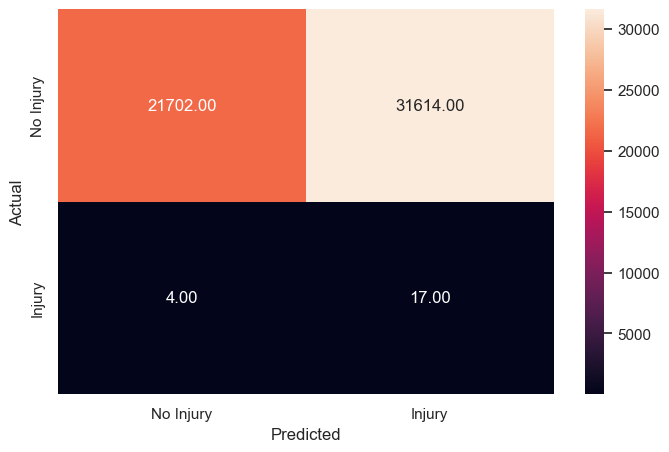

In [178]:
nn_test = metrics_score(y_test,y_pred_nn,'Weighted Neural Network')

In [179]:
nn_testset = nn_testset.append(nn_test, ignore_index = True)
nn_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1348200038.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_testset = nn_testset.append(nn_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,Basic Neural Network,0.999606,1.000000,0.000000,0.000000,0.000000,0.500000
1,Weighted Neural Network,0.407203,0.190476,0.809524,0.000537,0.001074,0.608284


### Try ANN with Undersampled Data

In [180]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train_nm,y_train_nm,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
11/11 [==============================] - 0s 11ms/step - loss: 1.6115 - accuracy: 0.4371 - val_loss: 1.0649 - val_accuracy: 0.6471
Epoch 2/5
11/11 [==============================] - 0s 2ms/step - loss: 1.3057 - accuracy: 0.4702 - val_loss: 1.0830 - val_accuracy: 0.5294
Epoch 3/5
11/11 [==============================] - 0s 2ms/step - loss: 1.0945 - accuracy: 0.5099 - val_loss: 1.1772 - val_accuracy: 0.5294
Epoch 4/5
11/11 [==============================] - 0s 2ms/step - loss: 1.0205 - accuracy: 0.5033 - val_loss: 1.2650 - val_accuracy: 0.5294
Epoch 5/5
11/11 [==============================] - 0s 2ms/step - loss: 0.9897 - accuracy: 0.5497 - val_loss: 1.2504 - val_accuracy: 0.5294


In [181]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 1s 482us/step


In [182]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      0.55      0.71     53316
           1       0.00      0.62      0.00        21

    accuracy                           0.55     53337
   macro avg       0.50      0.59      0.36     53337
weighted avg       1.00      0.55      0.71     53337



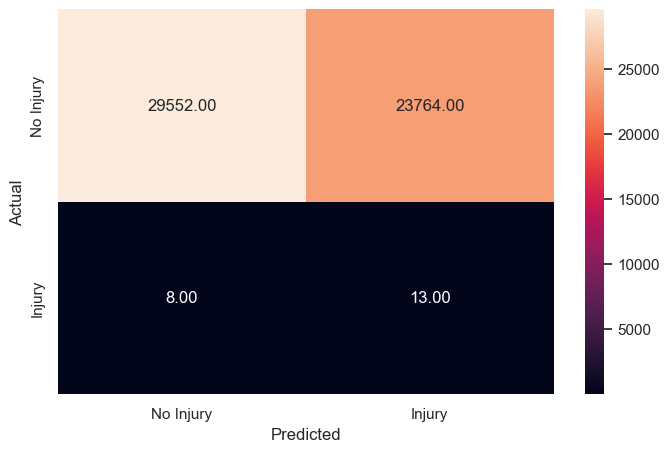

In [183]:
nn_test = metrics_score(y_test,y_pred_nn,'Undersampled Neural Network')

In [184]:
nn_testset = nn_testset.append(nn_test, ignore_index = True)
nn_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1348200038.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_testset = nn_testset.append(nn_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,Basic Neural Network,0.999606,1.000000,0.000000,0.000000,0.000000,0.500000
1,Weighted Neural Network,0.407203,0.190476,0.809524,0.000537,0.001074,0.608284
2,Undersampled Neural Network,0.554306,0.380952,0.619048,0.000547,0.001093,0.586664


### Oversampled Neural Network

In [185]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train_a,y_train_a,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
25591/25591 [==============================] - 18s 682us/step - loss: 0.1340 - accuracy: 0.9447 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 2/5
25591/25591 [==============================] - 16s 619us/step - loss: 0.0502 - accuracy: 0.9838 - val_loss: 0.0491 - val_accuracy: 0.9760
Epoch 3/5
25591/25591 [==============================] - 16s 617us/step - loss: 0.0334 - accuracy: 0.9897 - val_loss: 0.0125 - val_accuracy: 0.9938
Epoch 4/5
25591/25591 [==============================] - 16s 618us/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.0569 - val_accuracy: 0.9729
Epoch 5/5
25591/25591 [==============================] - 16s 619us/step - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0017 - val_accuracy: 1.0000


In [186]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 1s 307us/step


In [187]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



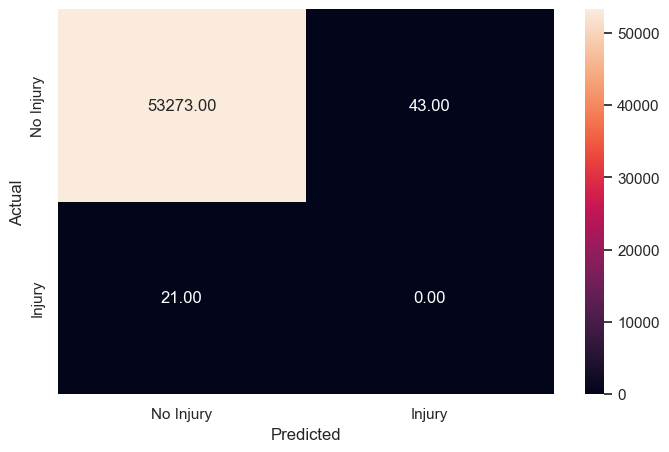

In [188]:
nn_test = metrics_score(y_test,y_pred_nn,'Oversampled Neural Network')

In [189]:
nn_testset = nn_testset.append(nn_test, ignore_index = True)
nn_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1348200038.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nn_testset = nn_testset.append(nn_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,Basic Neural Network,0.999606,1.000000,0.000000,0.000000,0.000000,0.500000
1,Weighted Neural Network,0.407203,0.190476,0.809524,0.000537,0.001074,0.608284
2,Undersampled Neural Network,0.554306,0.380952,0.619048,0.000547,0.001093,0.586664
3,Oversampled Neural Network,0.998800,1.000000,0.000000,0.000000,0.000000,0.499597


### Build CNN

In [190]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(41, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=.0001), loss='binary_crossentropy', metrics=['accuracy'])

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [191]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 64)            256       
                                                                 
 batch_normalization_2 (Batc  (None, 39, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                      

In [192]:
model.fit(X_train,y_train,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
12801/12801 [==============================] - 20s 2ms/step - loss: 0.0050 - accuracy: 0.9992 - val_loss: 0.0022 - val_accuracy: 0.9998
Epoch 2/5
12801/12801 [==============================] - 20s 2ms/step - loss: 0.0041 - accuracy: 0.9996 - val_loss: 0.0020 - val_accuracy: 0.9998
Epoch 3/5
12801/12801 [==============================] - 18s 1ms/step - loss: 0.0041 - accuracy: 0.9996 - val_loss: 0.0019 - val_accuracy: 0.9998
Epoch 4/5
12801/12801 [==============================] - 18s 1ms/step - loss: 0.0041 - accuracy: 0.9996 - val_loss: 0.0019 - val_accuracy: 0.9998
Epoch 5/5
12801/12801 [==============================] - 18s 1ms/step - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9998


In [193]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 1s 730us/step


In [194]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

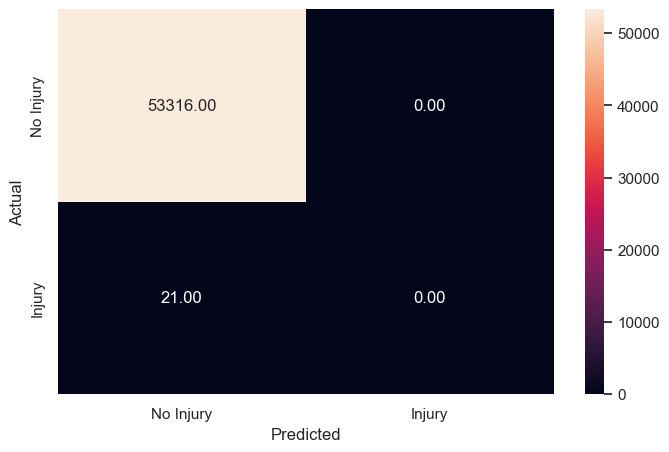

In [195]:
cnn_test = metrics_score(y_test,y_pred_nn,'Convolutional Neural Network')

In [196]:
cnn_testset = cnn_test
cnn_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,Convolutional Neural Network,0.999606,1.0,0.0,0.0,0.0,0.5


### Weighted CNN

In [197]:
model.fit(X_train,y_train,batch_size=15,epochs=5,class_weight=class_weights,validation_split=0.1,verbose=1)

Epoch 1/5
12801/12801 [==============================] - 19s 1ms/step - loss: 1.6228 - accuracy: 0.9981 - val_loss: 0.2958 - val_accuracy: 0.9995
Epoch 2/5
12801/12801 [==============================] - 18s 1ms/step - loss: 1.1198 - accuracy: 0.7172 - val_loss: 0.0263 - val_accuracy: 0.9998
Epoch 3/5
12801/12801 [==============================] - 19s 1ms/step - loss: 1.4220 - accuracy: 0.6141 - val_loss: 2.1714 - val_accuracy: 0.0894
Epoch 4/5
12801/12801 [==============================] - 19s 2ms/step - loss: 1.5979 - accuracy: 0.5941 - val_loss: 0.7523 - val_accuracy: 0.5844
Epoch 5/5
12801/12801 [==============================] - 19s 1ms/step - loss: 1.9834 - accuracy: 0.5440 - val_loss: 0.3078 - val_accuracy: 0.8674


In [198]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 1s 749us/step


In [199]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     53316
           1       0.00      0.19      0.00        21

    accuracy                           0.87     53337
   macro avg       0.50      0.53      0.47     53337
weighted avg       1.00      0.87      0.93     53337



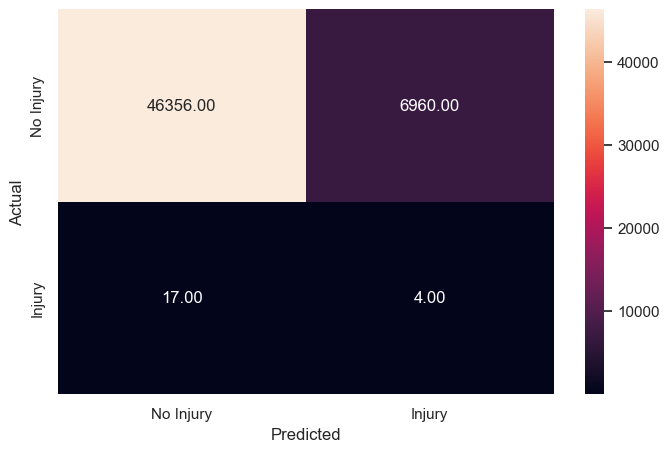

In [200]:
cnn_test = metrics_score(y_test,y_pred_nn,'Weighted Convolutional Neural Network')

In [201]:
cnn_testset = cnn_testset.append(cnn_test, ignore_index = True)
cnn_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1341132990.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnn_testset = cnn_testset.append(cnn_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,Convolutional Neural Network,0.999606,1.000000,0.000000,0.000000,0.000000,0.500000
1,Weighted Convolutional Neural Network,0.869190,0.809524,0.190476,0.000574,0.001145,0.529967


### Undersampled CNN

In [202]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train_nm,y_train_nm,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
11/11 [==============================] - 0s 10ms/step - loss: 1.2766 - accuracy: 0.5960 - val_loss: 0.8677 - val_accuracy: 0.6471
Epoch 2/5
11/11 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.7748 - val_loss: 1.0163 - val_accuracy: 0.6471
Epoch 3/5
11/11 [==============================] - 0s 3ms/step - loss: 0.4936 - accuracy: 0.8146 - val_loss: 0.2721 - val_accuracy: 0.8235
Epoch 4/5
11/11 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.7417 - val_loss: 0.8736 - val_accuracy: 0.6471
Epoch 5/5
11/11 [==============================] - 0s 3ms/step - loss: 0.4222 - accuracy: 0.8344 - val_loss: 1.3274 - val_accuracy: 0.6471


In [203]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 1s 753us/step


In [204]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      0.33      0.50     53316
           1       0.00      0.76      0.00        21

    accuracy                           0.33     53337
   macro avg       0.50      0.55      0.25     53337
weighted avg       1.00      0.33      0.50     53337



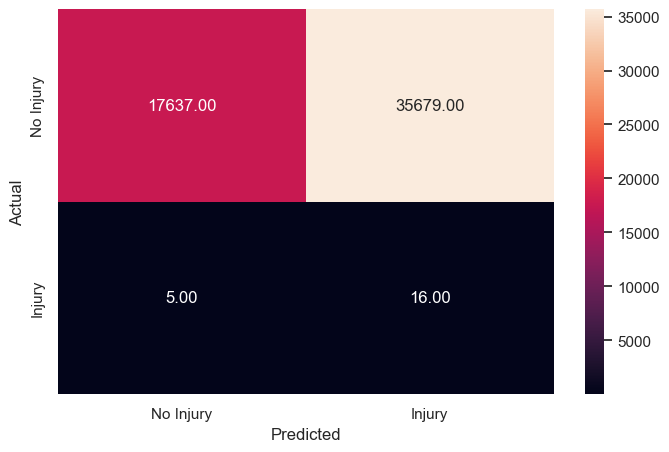

In [205]:
cnn_test = metrics_score(y_test,y_pred_nn,'Undersampled Convolutional Neural Network')

In [206]:
cnn_testset = cnn_testset.append(cnn_test, ignore_index = True)
cnn_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1341132990.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnn_testset = cnn_testset.append(cnn_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,Convolutional Neural Network,0.999606,1.000000,0.000000,0.000000,0.000000,0.500000
1,Weighted Convolutional Neural Network,0.869190,0.809524,0.190476,0.000574,0.001145,0.529967
2,Undersampled Convolutional Neural Network,0.330971,0.238095,0.761905,0.000448,0.000896,0.546353


### Oversampled CNN

In [207]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train_a,y_train_a,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
25591/25591 [==============================] - 39s 1ms/step - loss: 0.0549 - accuracy: 0.9786 - val_loss: 0.1493 - val_accuracy: 0.9755
Epoch 2/5
25591/25591 [==============================] - 36s 1ms/step - loss: 0.0067 - accuracy: 0.9986 - val_loss: 0.1909 - val_accuracy: 0.9736
Epoch 3/5
25591/25591 [==============================] - 36s 1ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.1979 - val_accuracy: 0.9731
Epoch 4/5
25591/25591 [==============================] - 36s 1ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.1617 - val_accuracy: 0.9730
Epoch 5/5
25591/25591 [==============================] - 35s 1ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.1857 - val_accuracy: 0.9760


In [208]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 1s 754us/step


In [209]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



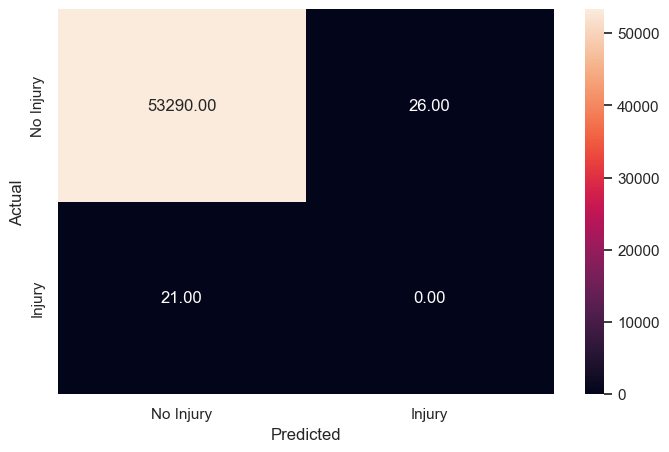

In [210]:
cnn_test = metrics_score(y_test,y_pred_nn,'Oversampled Convolutional Neural Network')

In [211]:
cnn_testset = cnn_testset.append(cnn_test, ignore_index = True)
cnn_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1341132990.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnn_testset = cnn_testset.append(cnn_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,Convolutional Neural Network,0.999606,1.000000,0.000000,0.000000,0.000000,0.500000
1,Weighted Convolutional Neural Network,0.869190,0.809524,0.190476,0.000574,0.001145,0.529967
2,Undersampled Convolutional Neural Network,0.330971,0.238095,0.761905,0.000448,0.000896,0.546353
3,Oversampled Convolutional Neural Network,0.999119,1.000000,0.000000,0.000000,0.000000,0.499756


### Build GRU RNN

In [212]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.GRU(64, input_shape=(41,1)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,345
Trainable params: 17,217
Non-trainable params: 128
_________________________________________________________________
None


In [213]:
model.compile(Adam(lr=.0001), loss='binary_crossentropy', metrics=['accuracy'])

/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [214]:
model.fit(X_train,y_train,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
12801/12801 [==============================] - 95s 7ms/step - loss: 0.0128 - accuracy: 0.9986 - val_loss: 0.0020 - val_accuracy: 0.9998
Epoch 2/5
12801/12801 [==============================] - 95s 7ms/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 0.9998
Epoch 3/5
12801/12801 [==============================] - 94s 7ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 0.0019 - val_accuracy: 0.9998
Epoch 4/5
12801/12801 [==============================] - 97s 8ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.0019 - val_accuracy: 0.9998
Epoch 5/5
12801/12801 [==============================] - 95s 7ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.0018 - val_accuracy: 0.9998


In [215]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 5s 3ms/step


In [216]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushalgourikrishna/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

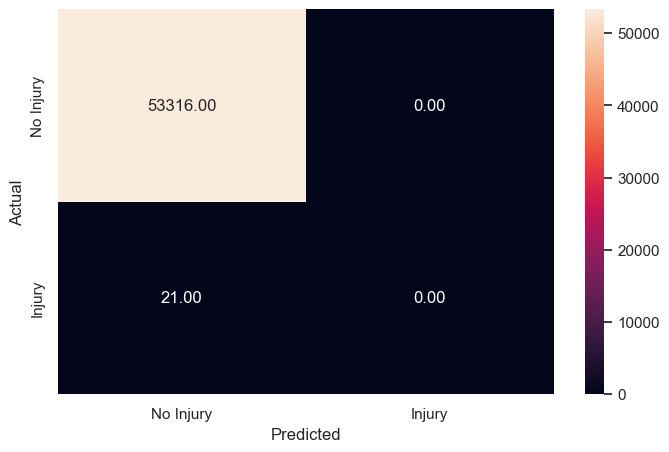

In [217]:
gru_test = metrics_score(y_test,y_pred_nn,'GRU RNN')

In [218]:
gru_testset = gru_test
gru_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,GRU RNN,0.999606,1.0,0.0,0.0,0.0,0.5


### Undersampled GRU

In [219]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train_nm,y_train_nm,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
11/11 [==============================] - 1s 28ms/step - loss: 2.9711 - accuracy: 0.5563 - val_loss: 12.8707 - val_accuracy: 0.0000e+00
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 1.5387 - accuracy: 0.5828 - val_loss: 3.2821 - val_accuracy: 0.1765
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.8391 - accuracy: 0.5232 - val_loss: 1.3403 - val_accuracy: 0.3529
Epoch 4/5
11/11 [==============================] - 0s 10ms/step - loss: 0.8037 - accuracy: 0.5960 - val_loss: 12.5318 - val_accuracy: 0.0000e+00
Epoch 5/5
11/11 [==============================] - 0s 9ms/step - loss: 0.6049 - accuracy: 0.6821 - val_loss: 2.7013 - val_accuracy: 0.1176


In [220]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 5s 3ms/step


In [221]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     53316
           1       0.00      0.38      0.00        21

    accuracy                           0.82     53337
   macro avg       0.50      0.60      0.45     53337
weighted avg       1.00      0.82      0.90     53337



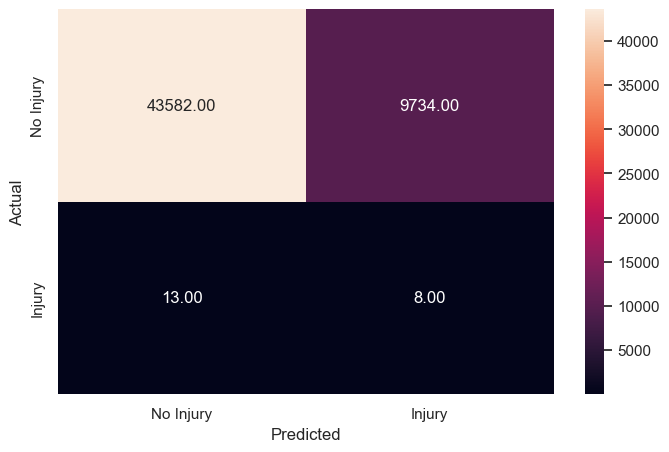

In [222]:
gru_test = metrics_score(y_test,y_pred_nn,'Undersampled GRU RNN')

In [223]:
gru_testset = gru_testset.append(gru_test, ignore_index = True)
gru_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1389952544.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gru_testset = gru_testset.append(gru_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,GRU RNN,0.999606,1.000000,0.000000,0.000000,0.000000,0.50000
1,Undersampled GRU RNN,0.817256,0.619048,0.380952,0.000821,0.001639,0.59919


### Oversampled GRU

In [224]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train_a,y_train_a,batch_size=15,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
25591/25591 [==============================] - 194s 8ms/step - loss: 0.0170 - accuracy: 0.9957 - val_loss: 1.6149e-05 - val_accuracy: 1.0000
Epoch 2/5
25591/25591 [==============================] - 193s 8ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 4.0059e-06 - val_accuracy: 1.0000
Epoch 3/5
25591/25591 [==============================] - 197s 8ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 8.4083e-09 - val_accuracy: 1.0000
Epoch 4/5
25591/25591 [==============================] - 196s 8ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 4.6875e-04 - val_accuracy: 1.0000
Epoch 5/5
25591/25591 [==============================] - 194s 8ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 1.4566e-08 - val_accuracy: 1.0000


In [225]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 4s 3ms/step


In [226]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53316
           1       0.00      0.00      0.00        21

    accuracy                           1.00     53337
   macro avg       0.50      0.50      0.50     53337
weighted avg       1.00      1.00      1.00     53337



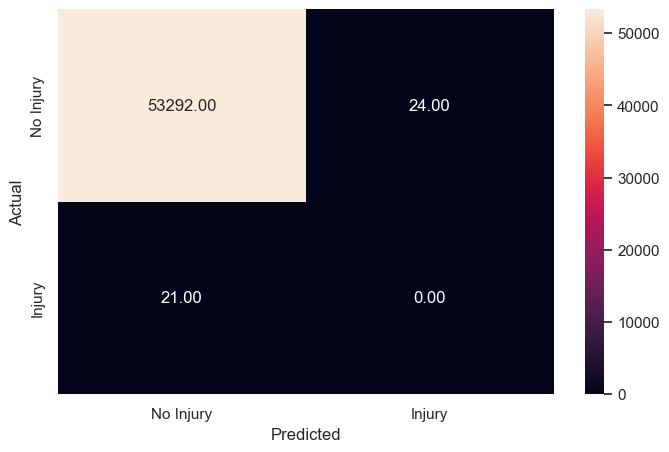

In [227]:
gru_test = metrics_score(y_test,y_pred_nn,'Oversampled GRU RNN')

In [228]:
gru_testset = gru_testset.append(gru_test, ignore_index = True)
gru_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1389952544.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gru_testset = gru_testset.append(gru_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,GRU RNN,0.999606,1.000000,0.000000,0.000000,0.000000,0.500000
1,Undersampled GRU RNN,0.817256,0.619048,0.380952,0.000821,0.001639,0.599190
2,Oversampled GRU RNN,0.999156,1.000000,0.000000,0.000000,0.000000,0.499775


### Weighted GRU

In [229]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=15,epochs=5,class_weight=class_weights,validation_split=0.1,verbose=1)

Epoch 1/5
12801/12801 [==============================] - 112s 9ms/step - loss: 2.4997 - accuracy: 0.7235 - val_loss: 0.0743 - val_accuracy: 0.9715
Epoch 2/5
12801/12801 [==============================] - 97s 8ms/step - loss: 1.5360 - accuracy: 0.6063 - val_loss: 0.5806 - val_accuracy: 0.8140
Epoch 3/5
12801/12801 [==============================] - 94s 7ms/step - loss: 1.4661 - accuracy: 0.5589 - val_loss: 0.5852 - val_accuracy: 0.6897
Epoch 4/5
12801/12801 [==============================] - 91s 7ms/step - loss: 1.3233 - accuracy: 0.5176 - val_loss: 6.3818 - val_accuracy: 0.3386
Epoch 5/5
12801/12801 [==============================] - 89s 7ms/step - loss: 1.9720 - accuracy: 0.5958 - val_loss: 0.6502 - val_accuracy: 0.6350


In [230]:
#Predict the response for test dataset
y_pred_nn = model.predict(X_test)

1667/1667 [==============================] - 5s 3ms/step


In [231]:
for i in range(len(y_test)):
    if y_pred_nn[i]>0.5:
        y_pred_nn[i]=1 
    else:
        y_pred_nn[i]=0

              precision    recall  f1-score   support

           0       1.00      0.63      0.77     53316
           1       0.00      0.24      0.00        21

    accuracy                           0.63     53337
   macro avg       0.50      0.43      0.39     53337
weighted avg       1.00      0.63      0.77     53337



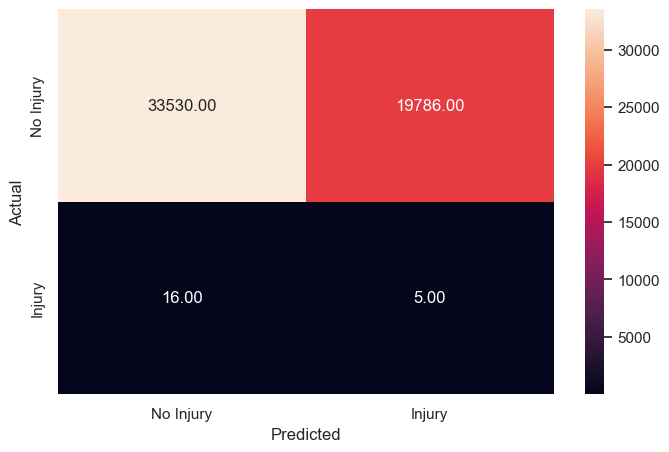

In [232]:
gru_test = metrics_score(y_test,y_pred_nn,'Weighted GRU RNN')

In [233]:
gru_testset = gru_testset.append(gru_test, ignore_index = True)
gru_testset 

/var/folders/rv/fk9_h9c11mjd0khq3hzr0yqc0000gn/T/ipykernel_58695/1389952544.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gru_testset = gru_testset.append(gru_test, ignore_index = True)


,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score,ROC_AUC
0,GRU RNN,0.999606,1.000000,0.000000,0.000000,0.000000,0.500000
1,Undersampled GRU RNN,0.817256,0.619048,0.380952,0.000821,0.001639,0.599190
2,Oversampled GRU RNN,0.999156,1.000000,0.000000,0.000000,0.000000,0.499775
3,Weighted GRU RNN,0.628738,0.761905,0.238095,0.000253,0.000505,0.433494
